In [1]:
from common import *
import mahotas
from scipy import spatial

In [66]:
db = load_db(download_tar("http://vision.lems.brown.edu/sites/default/files/216db.tar.gz"))

216db exists. Skipping


In [3]:
def query(image, descriptor, distance, top_n = 5, db=db):

    C = np.stack([descriptor(im) for im in db.image])

    desc = descriptor(image)
    dists = distance( desc, C )

    
    return db.iloc[np.argsort(dists)].head(n=top_n)


def test_queries(descriptor, distance, top_n=5):

    desc = [descriptor(im) for im in db.image]
    db["desc"]=desc

    queries = []
    results=[]
    for clas in db.clas.unique():
        row = db.query(f"clas=='{clas}'").sample(1).iloc[0]

        C = np.stack(db.desc.to_numpy())

        desc = row.desc
        dists = distance( row.desc, C)

        queries.append(pd.DataFrame(data=[row]))#[["clas","image"]])
        results.append(db.iloc[np.argsort(dists)].head(n=top_n))#[["clas","image"]])
    
    return queries, results

def query_acc(query, result):
    return np.sum(result.clas == query.clas.iloc[0])/len(result)

def query_accuracies(queries, results):
    res = pd.DataFrame()
    for q, r in zip(queries,results):
        res[f"{q.clas.iloc[0]}"]=pd.Series(query_acc(q,r))
    res.index.rename("Accuracy", inplace=True)
    return res


In [4]:
def show_query_results(queries, results):
    qDf = {}
    rDf = pd.DataFrame()
    for i, (q, r) in enumerate(zip(queries, results)):
        qDf[f"{q.clas.iloc[0]}"] = q.image.iloc[0]
        rDf[f"{q.clas.iloc[0]}"] = r.image.reset_index(drop=True)

    print("queries:")
    displayImages(pd.DataFrame(data=[qDf]))
    print("results:")
    displayImages(rDf)

def show_query_accuracy(queries, results):
    print("Accuracies:")
    acc = query_accuracies(queries,results)
    display(acc)
    print(f"Average along classes: {acc.transpose().mean().iloc[0]:.2f}")

In [5]:
def hu_moments(im):
    im = 255*(im==0).astype(np.uint8)
    h=cv2.moments(im)

    return cv2.HuMoments(h).flatten()

def log_transform(vec):
    return -1* np.copysign(1.0, vec) * np.log10(abs(vec))

def hu_moments_log(im):
    hu = hu_moments(im)
    return log_transform(hu)


def l1Dist(vec, dataset):
    return np.linalg.norm( vec.reshape(1,-1) - dataset , axis=-1, ord=1)

def l2Dist(vec, dataset):
    return np.linalg.norm( vec.reshape(1,-1) - dataset , axis=-1, ord=2)

In [6]:
def regularize(image):

    A = np.vstack(np.where(image==0)[::-1])
    center = np.mean(A,axis=-1)
    A = A.T - center
    u, s, vt = np.linalg.svd(A)

    if np.linalg.det(vt) < 0:
        vt[0,:] = vt[0,:]*-1

    r= vt
    c = center
    dsize = (250,250)

    center_d = (dsize[0]/2, dsize[1]/2)
    W = np.zeros((2,3))
    W[:2,:2] = r 
    W[:2,2] = -r@c  + center_d

    im2 = cv2.warpAffine(255-image, W, dsize=dsize)
    return 255 - im2

In [7]:
displayDf(query(db.iloc[6].image, descriptor=hu_moments_log, distance=l2Dist, top_n=5))

,clas,num,image
6,children,06,"<img src=""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAH0AAAB7CAAAAAB8stDkAAACcElEQVRoBcXBQZIkNwDEMPL/j6ZPdoRnq7uU2sMAxi8yfpFxQf4Vf8PYyf/ELWMkf4hLxkgexBVjIs/ihrGQT+KCsZCPYmcs5LOYGQP5ImbGQL6ImTGQL2JmDOSLmBkD+SJmxkC+iJkxkC9iZgzki5gZC/ksZsZCPouZMZGPYmZM5KOYGSP5IGbGSD6ImTGTRzEzZvIkdsZOHsTOmMmT2BkzeRI7YyVP4oIxkkdxwdjIB7EzFvJZzIyFfBYz45x8FyPjnHwXI+OYfBcr45i8iJFxSt7EyDglr2JjnJI3MTJOyavYGKfkVWyMU/IqNsYpeRUb45S8io1xTN7ExjgmL2JkHJM3sTHOyYvYGOfkTUyMc/ImJsYxeRcL45i8i4VxTN7Fwjgm72JhHJN3sTCOyYEYGOfkXQyMc3Igzhnn5F0MjHNyIM4Z5+RAnDPOyYE4ZwzkXZwzBnIgjhkDORDHjIUciFPGQg7EKWMhB+KUsZADccqYyLs4ZSzkXRwzFvIujhkDeRfnjIW8iYExkRcxMDbyXQyMjbyIc8ZIvoqBMZJvYmGM5LPYGCv5KDbGTD6IkbGTZzEybsij2BhX5ElsjCvyJDbGFXkSG+OKPImNcUWexMa4Ig9iZNyQJzEybsiDWBk35EGsjAvyJFbGBXkSK+OCPImVcUEexMy4IA9iZlyQBzEzLsiDmBkX5E+xMy7In2Jn3JCf4oJxQ36KC8YV+SEuGFfk/+KGcUV+iAvGHfkhdsYd+UOsjCvyJDbGFfkgBsYV+STOGTfkszhm3JDP4phxQz6Kc8YV+SAGxh15EhPjmvwQI+OvyH9iZvwi4xf9A1KX8gFcWkEVAAAAAElFTkSuQmCC"" width=""100"" >"
17,children,07,"<img src=""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAH4AAAB7CAAAAACXhWvnAAACcElEQVRoBcXBQZIkNwDEMPL/j6ZPDsfOVHcp5cMCxt9k/E3GBflX/C/GTP4U14yR/BK3jJE8iDvGRJ7FFWMiH8QNYyEfxQVjIZ/FzhjIF7EzBvJF7IyBfBMzYyDfxMwYyDcxMwbyReyMgXwRO2Mg38TMWMhnsTMW8lnsjIl8FDtjIx/FzNjIJ7EzVvJBzIyZPIqdsZMHccGYyZO4YMzkSVwwZvIgbhgreRQXjJE8ihvGRj6IC8ZCPoudsZAvYmYM5JuYGefku1gZx+RFrIxj8iJWxil5EyvjlLyKkXFK3sTKOCWvYmScklcxMk7Ju9gYp+RVjIxT8ipGxjF5EyPjmLyIlXFM3sTIOCcvYmSckzexMc7Jm9gY5+RVTIxj8i4mxjE5EAvjmLyLiXFMDsTCOCfvYmGck3exMM7JgRgY5+RADIyBvIuBcU5OxDljIO9iYAzkQJwzBnIgzhkLeRfnjIUciGPGQg7EMWMhJ+KUMZEDccpYyIk4ZUzkXRwzFvIuzhkLeRUDYyJvYmBM5EUsjI18FwtjJN/FwBjJV7EwRvJNTIyVfBYbYyUfxciYyQexMnbyQYyMG/IoRsYVeRIj44o8io1xRZ7EyLgiT2JkXJEnMTKuyJMYGVfkQayMG/IkVsYNeRAz44I8iZlxQZ7EzNjJo5gZO3kUM+OCPIidcUEexM64IA9iZ1yQB7EzbsgvccG4Ib/EBeOG/BQ3jCvyU1wwrsgPccO4I3+KG8Yd+SEuGHfkl5gZd+S3WBlX5FlMjCvyUZwzbshncc64IZ/FOeOGfBQD44p8EAvjjjyJjXHL5E+xMv4X+U/MjL/J+Jv+AZak8wG7Qn4AAAAAAElFTkSuQmCC"" width=""100"" >"
40,children,10,"<img src=""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAH8AAAB7CAAAAAB4RwDZAAACcElEQVRoBcXBQZIkNwDEMPL/j6ZPdoRnqruU2sMCxl9l/FXGDflX/BFjJ/8T94yV/BK3jJE8iTvGRp7FFWMin8QNYyIfxQVjIZ/FBWMhX8TOGMg3sTMG8k3sjIF8EztjIN/EzhjIN7EzFvJF7IyFfBE7YyGfxQVjIp/FzpjIZ7EzNvJR7IyVfBA7YyUfxM6YyaO4YOzkSVwwdvIkLhg7eRA3jJk8iRvGTJ7EDWMkz+KGMZIP4oIxkY/igrGQL2JnDOSrmBnn5LuYGefkRayMY/ImVsYxeRMr45S8ipVxSl7Fyjgmr2JkHJNXMTKOyasYGcfkVYyMY/IqRsYxeRMr45y8iZFxTl7Eyjgnb2JkDORFjIyBvImNcU7excQYyKuYGAN5FRPjnLyLiTGQd7EwzsmBWBgDeRcLYyDvYmEM5EAMjIW8i4GxkHcxMBZyIM4ZCzkQ54yJvItzxkQOxDFjIgfimDGRE3HKmMiJOGVM5EScMiZyIk4ZG3kXx4yNvIpzxkbexMDYyItYGCP5KibGSL6LhTGS72JhrOSrWBgr+SYmxko+i5Exk09iZczkk1gZO/kgVsYNeRYj44o8iZVxRR7FyLgij2JkXJFHMTKuyJNYGVfkSayMK/IgZsYNeRIz44Y8iJ1xQx7EzrggT2JnXJAnsTN28ih2xgV5EjvjgjyIC8YFeRAXjBvyW1wwbshvccG4Ib/EDeOG/BI3jCvyQ1wxrshPccO4Ij/EFeOO/BA3jDvyS+yMK/IgZsYVeRQj44Z8FgPjhnwWA+OKfBbnjBvyRZwzrshncc64Ix/Ewrhl8kOsjD8i/4kLxl9l/FX/APKP8wFYPPQuAAAAAElFTkSuQmCC"" width=""100"" >"
214,children,14,"<img src=""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAH8AAAB8CAAAAABlQjBhAAACdUlEQVRoBcXBMYLYNhDAQOD/j0ZSubiTRO668IzxTxn/lLEh/4u/ZyzIHxl/wZiSn2LNGJLfYsuYkUexY4zIi1gxJuRVbBgT8i4WjAH5EAvGgHyJOWNAPsSCMSBfYs64J19iwRiQLzFnDMiHWDAG5EvMGRPyLhaMCXkXC8aEvIsFY0RexYIxI69izhiSF7FgTMmzWDCm5FksGGPyJDaMMXkSG8aYPIkNY0yexIYxJI9ixRiSZ7FhjMib2DAm5F0sGAPyJeaMAfkSc8Y9+RZjxj35FmPGNTmIMeOWnMSYcUuOYsq4JUcxZdySo5gyrslRDBnX5CSmjGtyFEPGNTmJKeOanMSUcU8OYsq4JwcxZdyTg5gyBuQghowBOYgh454cxYwxICcxYwzIUYwY9+QsRowBOYoRY0COYsSYkKOYMCbkKCaMCTmLAWNCzmLAGJGjGDBG5CzuGSNyFveMETmLe8aE3IhrxohciGvGhFyJW8aI3IhbxoRciVvGiFyIa8aIXIhrxogcxYAxIicxYczItxgxZuRbjBhD8ilGjCH5FhPGkHyKEWNIvsSMMSWvYsqYkjcxZozJs5gz5uRRzBkL8ijGjA15EmPGijyIMWNDnsSYsSEPYs5Ykd9iztiQBzFnbMhvsWAsyINYMObkQWwYC/JbbBhz8iA2jDl5EBvGnDyJBWNOHsSGMScPYsOYk99ixZiTB7FhzMlvsWIsyC+xYizIT7FjbMgPsWNsyA+xY2zID7FjbMhPsWKsyE+xYWzIg5gzNuRRTBkL8ipGjAV5FxPGgnyIAWNBPsSAsSGvYsJYkRcxYiyZ/BBjxt+QP2LD+KeMf+o/XcL2ARUGdOUAAAAASUVORK5CYII="" width=""100"" >"
199,children,11,"<img src=""data:image/png;base64, iVBORw0KGgoAA

In [8]:
queries, results = test_queries(hu_moments, l1Dist, top_n=5)
show_query_results(queries, results)
show_query_accuracy(queries, results)

queries:


,elephant,turtle,classic,key,bird,brick,children,camel,fork,fountain,heart,car,bone,ray,hammer,face,misk,glas
0,"<img src=""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAHMAAABiCAAAAABGorMEAAADJklEQVRoBb3BAWKiQADAwOT/j86BWt1FsLVynTH+nPHnjD9nfMcAM05iHJJZnMM4JBtxCuOAPIszGPtkT5zA2CW74gTGHjkSHzN2yHeS+CXjmfxU/ILxRN4R7zK25D3xJmNL3hVvMTbkbfEWY0PeFm8xNuR98Q5jJr+SmWF8y9iQT8VrxoZ8LF4yNuQMccyYyTnikLEh54gjxoacJA4YKyGu5DSxy1gJxErOE7uMKyFWcp7YY9wIsZATxQ7jSlaBnCmeGTfyX8QT44v8F7FlPMj/EBvGSP6DmBkzOV9MjIn8BzExJvIlbuRjMTImchN38rEYGCO5iQf5WAyMiVzEQD4XD8ZILmIgJ4gHYySrGMkZ4s4YySpGcoJ4MAayipmcIO6MgaxiIieIB2Mgi5jJGeLOeJBVzOQMcWc8yCpmcoa4M+5kFRtygngw7uQiNuRz8WDcySo25ATxYHyRVWzJ52JgfJFFPJHPxcC4kVU8k0/FyPgii3giH4uRcSOLeCafiolxJat4Ip+JLeNCLuKJfCg2jAtZxTP5VMyMlaxih3wsJsZKVvFMjoT8UIyMhaxihxyJhfxIDAyQi9ghR+LGkNdiYICsYoccizv5RjwYyCr2yLG4k+/EnQGyiB3yQnyRb8WdAULskhfii3wvvhgLY5+8EjfyA3FjvCKvxI38QNwYL8gkZBRXMglkT1wYL8gkmcSVjAJkT1wYL8gkZBIXMooLeRYr45hMAhnFlYziSp7Eyjgmk0AmsZJJfJGNWBnHZBLILBYyipGMYmUckkmATGIlo5jIKBbGMRnESiaxkFHM5CFWxiEZxUomsZBRTGQUC+OQjGIlk1jIKCYyioVxSAZxJaMAGcVEJrEwDskgrmQUIKMYyUaAcURGcSOjkEmMZCPAOCCTuJFBgIxiIFsBxj7ZiAuZhExiIE8CY5dsxYVMklkMZCvA2CVPYiGzkEkMZCvA2CVbsZCNkFGMZCMWxi7ZioVsxEqIXfIQV8Yu2YiFPIlvGcaDcUAGcSFb8T7jiEBC3MlWvM94g2zF+4x3yEa8z3iPPMSvGO8yM+O3jD9n/Dnjz/0DdRg2EIm9L04AAAAASUVORK5CYII="" width=""100"" >","<img src=""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAHMAAABWCAAAAADZSfa/AAAB6klEQVRoBb3BCZLiMADAQOn/j9aGJcBcQGyn6DY+zvg44+OM05gZbxnnkIfAjCeMM8gT8ZuxQpLX4idjgRwQPxjT5KD4xpglh8VXxiQZEQ/GBBkWd8Y4mRA3xjCZFhtjkKwIMMbImsAYImsCjBGyKjBGyKIAY4CsCjCOk1WxMY6SdbExjpETxIVxjKyL/4xDZF1cGYfIurgyjpATxJVxgJwgdsYBsi5ujANkXdwYB8iyuDPeknXxYLwjJ4gH4w05T1wYb8h54sJ4TU4UF8ZrcqbYGC/JqWJjvCSnio3xipwswHhFzhUb4xU5V2yMF+RUSYDxlKyKjewCA4xnZEns5Cp2xhOyJG7kKnbG32RFPMgmiZ3xhMyLL2QTxs74m8yLLyQkHownZFJ8ZxhfGL8ZIHPiB+M74xdZEG8ZN2aALIgDjJ2siyOMjZwhjjE2si6OMkCWxXEGsiwGGCCLYoQBsiaGGCALYpSxkXkxyriQOTHBuJAZMcW4klExydjJkJhm3MlhscB4MPlbZvIQ84zv5LfYyV1MM/4gNxkP8hCzjD/IVXwnDzHLeML4Te5iljFC7mKWMURuYpYxRG5iljFEbmKWMURuYpYxRK5injFEdjHNGCK7mGaMkU0S04wxsokVxscZH2d8nPFx/wAc/MUBEtng0gAAAABJRU5ErkJggg=="" width=""100"" >","<img src=""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAHMAAAAwCAAAAAAH5Br4AAABJ0lEQVRYCb3BCXLbMADAQOD/j0ZFSb4ybRqFNneN5YzljOWMKYaBmZkZ/2P8hlwUD8YlJr8VB+MCmRODcYVMicG4QmbEzrhCpsRgXCFTYjCukCkxGFfIjNgZV8iUGIwrZEoMxgUyJwbjK0lISJI3isH4Qj4nBuOVfE7sjFfyQTEYd2bIB8VgnGSB2BgnWSA2xklWCDAOskSAsZM1AgyQZQIMkGUCjI0sEhsDZJXYGCCrxMYAWSMJMEDWSAIMZI0QAgNkjdgZIEvEwQB5uwCTZ3EwNvKdOJmZmZmZmRmD3MRJnsTB2Mh34mfkEA9yFydjkIfkVfyUYbyQU9wYO7kJ5FnMkSHujJMMMciTmGU8M+6Mk9zF2xl/JYd4P+MfzIwPMJYzljOW+wOfUIkBwpEbHgAAAABJRU5ErkJggg=="" width=""100"" >","<img src=""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAHQAAAA8CAAAAACS+sH6AAABV0lEQVRYCb3BB2LiQADAQOn/j9YZU45iJ2A2O2PMZ8xnzGfMZ+wwIWM8Y4esYjxjm1zEcMYmuYnRjC1yL8YyNsiDGMt4JU9iKOOFbIhxjGeyJ2ME44n8JAYw7sk74jvGHXlP/M6QkJPMjDPjjrwpnphh3MirODOu5H3JEbEyLmSCODHOZIY4MVYyRyyMhUwTYCxkmgBjIbPEwljIJHFiLGSOWBkLmSLOjBOZIC6MhfyxhLgyFvKn4pGxkK+EEAu5E3IST4yFHJXEibGSqwDJeGYs5KA4wljIQXGEcSIfCyGOMFbyqZA4xDiTz8RxxpV8Io4zbuRd8RXjP3lTfMV4IL+I7xmP5AcZAxiPZFcMYryQTTGK8Uo2xDDGBnkWAxkb5FkMZGySBzGSsU0exEDGDrmJsYw9chGDGbtkFaMZ+2QVgxm7ZBWjGftkEcMZ8xnzGfMZ8xnz/QN3wIkBHkImZAAAAABJRU5ErkJggg=="" width=""100"" >","<img src=""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAHMAAABYCAAAAADjQ5fPAAAB5klEQVRoBb3BCYLaSADAQOn/j9ZOMht8YgNuU2V8nfF1xtcZC2bGrYwZeYjbGA+yEDcx/pG1uIXxP9mIWxi/ZE/cwPhLdsUNjL9kV9zA+CHPxHjGD3kqhjNAnovhDORADGeAPBfDGWBmhqzFeMacrMVwxoKsxHDGnKzFcMaCrMRwxoKsxHDGnGzEaMaCrMVoxoKsxWjGnGzFYMacbMVgxpxsxWDGjOyJsYw52RNDGTOyK4YyZmRfjGTMyBMxkDGRp2IcY0aeiXGMiRyIUYyJHIoxjImciBGMiZyK64wHeUVcZUzkJXGN8SCviiuMibwuPmY8yDviU8aDvCk+YkzkbfE+40E+Ee8yJvKZeIvxIJ+KdxgPckG8zHiQK+JVxkQuilcYExkgzhgTGSPjgDEjI2XsMWZkuNgwZuQWsWDMyS1izliQW8SMsSD3iImxJPeIB2NFbhEPxorcI/4x1uQu8ZexIXeJP4wdcpcAY4/cJMDYJ/cIjGfkBgHGAflA/CMbAcYheUNsyFKAccLkFRm7ZBI/jHNyKo7Ir/jDOCcn4pzEL+MFciTeY7xAnot3GedkX3zEeIFsxaeMU7IRFxgnZC2uMY7JSlxlHJGNuMo4Ij/il8mPuMg4IBALQlxjfJ3xdcbXGV/3H5xiuwHmgqQrAAAAAElFTkSuQmCC"" width=""100"" 

results:


,elephant,turtle,classic,key,bird,brick,children,camel,fork,fountain,heart,car,bone,ray,hammer,face,misk,glas
0,"<img src=""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAHMAAABiCAAAAABGorMEAAADJklEQVRoBb3BAWKiQADAwOT/j86BWt1FsLVynTH+nPHnjD9nfMcAM05iHJJZnMM4JBtxCuOAPIszGPtkT5zA2CW74gTGHjkSHzN2yHeS+CXjmfxU/ILxRN4R7zK25D3xJmNL3hVvMTbkbfEWY0PeFm8xNuR98Q5jJr+SmWF8y9iQT8VrxoZ8LF4yNuQMccyYyTnikLEh54gjxoacJA4YKyGu5DSxy1gJxErOE7uMKyFWcp7YY9wIsZATxQ7jSlaBnCmeGTfyX8QT44v8F7FlPMj/EBvGSP6DmBkzOV9MjIn8BzExJvIlbuRjMTImchN38rEYGCO5iQf5WAyMiVzEQD4XD8ZILmIgJ4gHYySrGMkZ4s4YySpGcoJ4MAayipmcIO6MgaxiIieIB2Mgi5jJGeLOeJBVzOQMcWc8yCpmcoa4M+5kFRtygngw7uQiNuRz8WDcySo25ATxYHyRVWzJ52JgfJFFPJHPxcC4kVU8k0/FyPgii3giH4uRcSOLeCafiolxJat4Ip+JLeNCLuKJfCg2jAtZxTP5VMyMlaxih3wsJsZKVvFMjoT8UIyMhaxihxyJhfxIDAyQi9ghR+LGkNdiYICsYoccizv5RjwYyCr2yLG4k+/EnQGyiB3yQnyRb8WdAULskhfii3wvvhgLY5+8EjfyA3FjvCKvxI38QNwYL8gkZBRXMglkT1wYL8gkmcSVjAJkT1wYL8gkZBIXMooLeRYr45hMAhnFlYziSp7Eyjgmk0AmsZJJfJGNWBnHZBLILBYyipGMYmUckkmATGIlo5jIKBbGMRnESiaxkFHM5CFWxiEZxUomsZBRTGQUC+OQjGIlk1jIKCYyioVxSAZxJaMAGcVEJrEwDskgrmQUIKMYyUaAcURGcSOjkEmMZCPAOCCTuJFBgIxiIFsBxj7ZiAuZhExiIE8CY5dsxYVMklkMZCvA2CVPYiGzkEkMZCvA2CVbsZCNkFGMZCMWxi7ZioVsxEqIXfIQV8Yu2YiFPIlvGcaDcUAGcSFb8T7jiEBC3MlWvM94g2zF+4x3yEa8z3iPPMSvGO8yM+O3jD9n/Dnjz/0DdRg2EIm9L04AAAAASUVORK5CYII="" width=""100"" >","<img src=""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAHMAAABWCAAAAADZSfa/AAAB6klEQVRoBb3BCZLiMADAQOn/j9aGJcBcQGyn6DY+zvg44+OM05gZbxnnkIfAjCeMM8gT8ZuxQpLX4idjgRwQPxjT5KD4xpglh8VXxiQZEQ/GBBkWd8Y4mRA3xjCZFhtjkKwIMMbImsAYImsCjBGyKjBGyKIAY4CsCjCOk1WxMY6SdbExjpETxIVxjKyL/4xDZF1cGYfIurgyjpATxJVxgJwgdsYBsi5ujANkXdwYB8iyuDPeknXxYLwjJ4gH4w05T1wYb8h54sJ4TU4UF8ZrcqbYGC/JqWJjvCSnio3xipwswHhFzhUb4xU5V2yMF+RUSYDxlKyKjewCA4xnZEns5Cp2xhOyJG7kKnbG32RFPMgmiZ3xhMyLL2QTxs74m8yLLyQkHownZFJ8ZxhfGL8ZIHPiB+M74xdZEG8ZN2aALIgDjJ2siyOMjZwhjjE2si6OMkCWxXEGsiwGGCCLYoQBsiaGGCALYpSxkXkxyriQOTHBuJAZMcW4klExydjJkJhm3MlhscB4MPlbZvIQ84zv5LfYyV1MM/4gNxkP8hCzjD/IVXwnDzHLeML4Te5iljFC7mKWMURuYpYxRG5iljFEbmKWMURuYpYxRK5injFEdjHNGCK7mGaMkU0S04wxsokVxscZH2d8nPFx/wAc/MUBEtng0gAAAABJRU5ErkJggg=="" width=""100"" >","<img src=""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAHMAAAAwCAAAAAAH5Br4AAABJ0lEQVRYCb3BCXLbMADAQOD/j0ZFSb4ybRqFNneN5YzljOWMKYaBmZkZ/2P8hlwUD8YlJr8VB+MCmRODcYVMicG4QmbEzrhCpsRgXCFTYjCukCkxGFfIjNgZV8iUGIwrZEoMxgUyJwbjK0lISJI3isH4Qj4nBuOVfE7sjFfyQTEYd2bIB8VgnGSB2BgnWSA2xklWCDAOskSAsZM1AgyQZQIMkGUCjI0sEhsDZJXYGCCrxMYAWSMJMEDWSAIMZI0QAgNkjdgZIEvEwQB5uwCTZ3EwNvKdOJmZmZmZmRmD3MRJnsTB2Mh34mfkEA9yFydjkIfkVfyUYbyQU9wYO7kJ5FnMkSHujJMMMciTmGU8M+6Mk9zF2xl/JYd4P+MfzIwPMJYzljOW+wOfUIkBwpEbHgAAAABJRU5ErkJggg=="" width=""100"" >","<img src=""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAHQAAAA8CAAAAACS+sH6AAABV0lEQVRYCb3BB2LiQADAQOn/j9YZU45iJ2A2O2PMZ8xnzGfMZ+wwIWM8Y4esYjxjm1zEcMYmuYnRjC1yL8YyNsiDGMt4JU9iKOOFbIhxjGeyJ2ME44n8JAYw7sk74jvGHXlP/M6QkJPMjDPjjrwpnphh3MirODOu5H3JEbEyLmSCODHOZIY4MVYyRyyMhUwTYCxkmgBjIbPEwljIJHFiLGSOWBkLmSLOjBOZIC6MhfyxhLgyFvKn4pGxkK+EEAu5E3IST4yFHJXEibGSqwDJeGYs5KA4wljIQXGEcSIfCyGOMFbyqZA4xDiTz8RxxpV8Io4zbuRd8RXjP3lTfMV4IL+I7xmP5AcZAxiPZFcMYryQTTGK8Uo2xDDGBnkWAxkb5FkMZGySBzGSsU0exEDGDrmJsYw9chGDGbtkFaMZ+2QVgxm7ZBWjGftkEcMZ8xnzGfMZ8xnz/QN3wIkBHkImZAAAAABJRU5ErkJggg=="" width=""100"" >","<img src=""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAHMAAABYCAAAAADjQ5fPAAAB5klEQVRoBb3BCYLaSADAQOn/j9ZOMht8YgNuU2V8nfF1xtcZC2bGrYwZeYjbGA+yEDcx/pG1uIXxP9mIWxi/ZE/cwPhLdsUNjL9kV9zA+CHPxHjGD3kqhjNAnovhDORADGeAPBfDGWBmhqzFeMacrMVwxoKsxHDGnKzFcMaCrMRwxoKsxHDGnGzEaMaCrMVoxoKsxWjGnGzFYMacbMVgxpxsxWDGjOyJsYw52RNDGTOyK4YyZmRfjGTMyBMxkDGRp2IcY0aeiXGMiRyIUYyJHIoxjImciBGMiZyK64wHeUVcZUzkJXGN8SCviiuMibwuPmY8yDviU8aDvCk+YkzkbfE+40E+Ee8yJvKZeIvxIJ+KdxgPckG8zHiQK+JVxkQuilcYExkgzhgTGSPjgDEjI2XsMWZkuNgwZuQWsWDMyS1izliQW8SMsSD3iImxJPeIB2NFbhEPxorcI/4x1uQu8ZexIXeJP4wdcpcAY4/cJMDYJ/cIjGfkBgHGAflA/CMbAcYheUNsyFKAccLkFRm7ZBI/jHNyKo7Ir/jDOCcn4pzEL+MFciTeY7xAnot3GedkX3zEeIFsxaeMU7IRFxgnZC2uMY7JSlxlHJGNuMo4Ij/il8mPuMg4IBALQlxjfJ3xdcbXGV/3H5xiuwHmgqQrAAAAAElFTkSuQmCC"" width=""100"" 

Accuracies:


,elephant,turtle,classic,key,bird,brick,children,camel,fork,fountain,heart,car,bone,ray,hammer,face,misk,glas
Accuracy,,,,,,,,,,,,,,,,,,
0,0.2,0.8,0.4,0.4,0.8,0.4,0.6,0.2,0.2,0.6,0.4,1.0,0.8,0.6,0.8,0.8,0.8,0.2


Average along classes: 0.56


In [9]:
queries, results = test_queries(hu_moments_log, l1Dist, top_n=5)
show_query_results(queries, results)
show_query_accuracy(queries, results)

queries:


,elephant,turtle,classic,key,bird,brick,children,camel,fork,fountain,heart,car,bone,ray,hammer,face,misk,glas
0,"<img src=""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAHMAAABmCAAAAADdM/ESAAADfklEQVRoBb3BC2KqWgIAwe79L7pHkM+BaJ4T8FYZ/5zxzxn/nPEpMzMz4++MD8lR/JXxO3kr/sb4jfwmdpLxEeM9+Q+xkFl8wnhL/ktMZBD/yXhH/ib+g/GO/FH8znhD/i5+Y7whfxe/MV6TS+I94yW5KN4yXpKL4i3jFbks3jFekBvEG8YLcot4yfhBbhIvGT/IXeIV4we5TbxgnMl94gXjTG4UPxlncqP4yTiRW8UPxoncK86MM7lVnBkncrM4MU7kbnFknMjd4sg4k5vFkXEit4sD40RuFwfGidwuDowTuV0cGEfyBTEyTuR+MTJO5H4xMo7kG2JgHMk3xMA4kq+InXEkXxE740i+InbGgXxJbIwD+ZLYGAfyJbExRvItsTFG8g0hsTFG8g0hsTEG8g0BEitjIN8QILEydvIN8SCxMnbyDfEgsTI28kLINfEgsTI28kLINfEgxMJYySshl8REiIWxkofkKOSSmAixMBbyEHIQyCUxEWJhLOQh5CCQS2ImsTBmMglkFCCXxExiYUxkEiCjALkkZhILYyKTANnFRC6JmcTCmMhDYLKLiVwSTxJPxkQgQDaxkEviSYiZAfIQD7KKlVwSCyEmBgjEkzzFSq6JJyEmBgKxkKdYyTXxJBAPBkisZBY7uSJWQjwYRzKLnVwSC3kIjCOZxU5+Eyt5KRYCAcaRzGInByGD2MgrsZCHwDiRSQxkFDKInbwQT0IGGCcyiYGMQgaxkxfixDiSWQxkFMgmdvJKnBgnMomRjEI2MZBVsokj40QmMZJRyCYGsghkFUfGiUxiJKNAVrGTVSCrODJOZBIjGQTIJnayCJBVHBhn8hAHsguQTexkESCrODBOZBIHsguQTWxkFQ+yiAPjRGYxkl2AbGInT/EgmxgZJzKLA9kEyCZ28hQTWcXIOJNJjGQXIJvYyCImsoqRcSKzOJBdIJvYyCImsomBcSaTOJBdyCZ2soiZrGJgnMgsDmQXsomdLGImqxgYZzKJA9mFbGIjq5jJKgbGmTzEkexCVrGRTcxkFQPjByFOZBeyio1s4kmeYmR8RHYhq1jJLp5kEQPjI7ILZBEb2cRMVjEwPiK7QBaxkl3MZBEj4yOyiQeZxUY28SRPcWB8RDYxkczYyCZmsogD4zOyiLeMA3mIM+NDMov/h/GT8SGZxHXGp8y4g/HPGf+c8c/9D88gZhDQiyFcAAAAAElFTkSuQmCC"" width=""100"" >","<img src=""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAHMAAAByCAAAAABFdLGfAAAClElEQVRoBb3BAWKCQADAsPb/j+506kQFRDiXGP/O+HfGvzP+nXElF/FtxpnJXXyVcSZP4nuME3kRX2OcyKv4FgNkTnyJATIv3jB2MEDmxSOB+GXyKz5mgCyJCZkXnzFOZEHcyZL4iHEii+JGlsUHjDNZEleyKjYzfpksiDN5JzYy/sgxsY1xJ8fEJsaEHBQbGFNyTGxgPJJj4i3jmRwS7xgzZL94x5gjB8Q6Y57sFuuMebJfrDIWyV6xxlgi+8UKY4EcEcuMeXJMLDLmyHGxwHglI8QC44UMErOMZzJMzDEeyUgxw3gkQ8Ur40a+IV4YV/Id8cy4ki+JJ8aVfEk8Ma5kVnJYPDCuZEYgh8UD40ZeBchhMWX8kSdxJgPEnTEhU3Ehx8WdMSETcSUDxB/jgdzEnRwXN8Yj+RVTclzcGM8MY8JkhLgw1skwcWGsk2Hiwlgn48Qv4x0ZJs6Md2SYODPeklHizHhLhokTYwMZJE6MLWSQAGMLuUgOiRNjG4EAOSTA+JAcEWB8SI4IMD4m+wUYH5P9AozPyW4Bxg6yV4Cxh+wUYOwhOwUYu8g+AcY+skuAsZPsECfGTrJDnBh7yefixNhNPhVnxm7yqTgzDpDPxJlxgHwkfhlHyAfiwjhCPhAXxiGyWVwZh8hWcWMcJNvEjXGUbBF/jMNkg/hjHCYbxB/jOHkr7owB5J24M0aQdTFhjCDrYsIYQlbFhDGErIoJYwhZE1PGGLImJowxZEVMGYPIspgyBpFlMWUMISvigTGCrIkHxgCyJh4ZI8iyeGIMIMvimTGALIoXxgCyIOOFMYTMiFnGEPIq5hmDyERyErOMUeQuBGKWMYz8CYSYZYwkZ3EiMc8YzfhlzDP+nfHvjH/3A4zZ+wFZ3QpZAAAAAElFTkSuQmCC"" width=""100"" >","<img src=""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAHMAAAAwCAAAAAAH5Br4AAABJ0lEQVRYCb3BCXLbMADAQOD/j0ZFSb4ybRqFNneN5YzljOWMKYaBmZkZ/2P8hlwUD8YlJr8VB+MCmRODcYVMicG4QmbEzrhCpsRgXCFTYjCukCkxGFfIjNgZV8iUGIwrZEoMxgUyJwbjK0lISJI3isH4Qj4nBuOVfE7sjFfyQTEYd2bIB8VgnGSB2BgnWSA2xklWCDAOskSAsZM1AgyQZQIMkGUCjI0sEhsDZJXYGCCrxMYAWSMJMEDWSAIMZI0QAgNkjdgZIEvEwQB5uwCTZ3EwNvKdOJmZmZmZmRmD3MRJnsTB2Mh34mfkEA9yFydjkIfkVfyUYbyQU9wYO7kJ5FnMkSHujJMMMciTmGU8M+6Mk9zF2xl/JYd4P+MfzIwPMJYzljOW+wOfUIkBwpEbHgAAAABJRU5ErkJggg=="" width=""100"" >","<img src=""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAHQAAAA5CAAAAADCN1BJAAABQElEQVRYCb3BCUJaQRQAwe77H7rzAI1EWT4ymSpjP2M/Yz9jP2M/4yFJLmIV4x4DuRKLGHfID7GGcYPcFGsY38ldsYTxjTwQKxjX5KFYwvgiT8QSxid5LlYwzkyeiyWMMzkiljDO5JBYwRjymniLMeRV8QZjyKviDcaQlwVyFnKWZDKSn+KDcSKvSl6VcWYM2SPOjCG7xDCGbBInxpBtAowh2wQYQ7YJMIbsEsMYsksMY8gmcWIM2SIujCFbxIUxZIP4ZAz5/+IvY8hqISQjIeOLMWSJ+GCAcWHGNWPIewKEOMYY8ivxO8aQ4+JM4reMIceE8T5jyDGxhDHkkFjDGHJIrGGcyBGxhnEhz8Uaxid5JtYwrskjsYbxD3kg1jB+kDtiDeMGuSFWMW4ySb6EsYjxgIyEjHWM/Yz9jP2M/f4Ap2yEAfKIXewAAAAASUVORK5CYII="" width=""100"" >","<img src=""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAHsAAAB7CAAAAABxrKCjAAACrElEQVRoBcXBAXKiQAAAwZn/P3ouOYOCosGwW3YbH2N8jPExxscYH2N8jPFAkoSYyrgnNzGRsSUbMY+xJVsxjbEmD2IWY0V2xCTGjeyJSYwb2RVzGD/kmZjD+CHPxQzGhTwXUxg/5KmYwriRJ2IGY012xQzGmuyKGYwt2REzGFuyI2Yw7sijmMG4I49iBuOePIgZjHvyIGYw7smjmMC4J49iAuOePIoJjHvyKCYw7smjmMC4IztiAuOO7IgJjDuyIyYwtmRPTGBsyZ6YwNiSPTGBsSG7YgJjQ/bFeMaa7IsJjDV5IsYz1mRfTGCsyDMxnrEiz8R4xo08F8MZK/JUDGdcyUsxmHElL8VgxpX8IoYyruRXMZCxkANiHGMhh8Qox

results:


,elephant,turtle,classic,key,bird,brick,children,camel,fork,fountain,heart,car,bone,ray,hammer,face,misk,glas
0,"<img src=""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAHMAAABmCAAAAADdM/ESAAADfklEQVRoBb3BC2KqWgIAwe79L7pHkM+BaJ4T8FYZ/5zxzxn/nPEpMzMz4++MD8lR/JXxO3kr/sb4jfwmdpLxEeM9+Q+xkFl8wnhL/ktMZBD/yXhH/ib+g/GO/FH8znhD/i5+Y7whfxe/MV6TS+I94yW5KN4yXpKL4i3jFbks3jFekBvEG8YLcot4yfhBbhIvGT/IXeIV4we5TbxgnMl94gXjTG4UPxlncqP4yTiRW8UPxoncK86MM7lVnBkncrM4MU7kbnFknMjd4sg4k5vFkXEit4sD40RuFwfGidwuDowTuV0cGEfyBTEyTuR+MTJO5H4xMo7kG2JgHMk3xMA4kq+InXEkXxE740i+InbGgXxJbIwD+ZLYGAfyJbExRvItsTFG8g0hsTFG8g0hsTEG8g0BEitjIN8QILEydvIN8SCxMnbyDfEgsTI28kLINfEgsTI28kLINfEgxMJYySshl8REiIWxkofkKOSSmAixMBbyEHIQyCUxEWJhLOQh5CCQS2ImsTBmMglkFCCXxExiYUxkEiCjALkkZhILYyKTANnFRC6JmcTCmMhDYLKLiVwSTxJPxkQgQDaxkEviSYiZAfIQD7KKlVwSCyEmBgjEkzzFSq6JJyEmBgKxkKdYyTXxJBAPBkisZBY7uSJWQjwYRzKLnVwSC3kIjCOZxU5+Eyt5KRYCAcaRzGInByGD2MgrsZCHwDiRSQxkFDKInbwQT0IGGCcyiYGMQgaxkxfixDiSWQxkFMgmdvJKnBgnMomRjEI2MZBVsokj40QmMZJRyCYGsghkFUfGiUxiJKNAVrGTVSCrODJOZBIjGQTIJnayCJBVHBhn8hAHsguQTexkESCrODBOZBIHsguQTWxkFQ+yiAPjRGYxkl2AbGInT/EgmxgZJzKLA9kEyCZ28hQTWcXIOJNJjGQXIJvYyCImsoqRcSKzOJBdIJvYyCImsomBcSaTOJBdyCZ2soiZrGJgnMgsDmQXsomdLGImqxgYZzKJA9mFbGIjq5jJKgbGmTzEkexCVrGRTcxkFQPjByFOZBeyio1s4kmeYmR8RHYhq1jJLp5kEQPjI7ILZBEb2cRMVjEwPiK7QBaxkl3MZBEj4yOyiQeZxUY28SRPcWB8RDYxkczYyCZmsogD4zOyiLeMA3mIM+NDMov/h/GT8SGZxHXGp8y4g/HPGf+c8c/9D88gZhDQiyFcAAAAAElFTkSuQmCC"" width=""100"" >","<img src=""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAHMAAAByCAAAAABFdLGfAAAClElEQVRoBb3BAWKCQADAsPb/j+506kQFRDiXGP/O+HfGvzP+nXElF/FtxpnJXXyVcSZP4nuME3kRX2OcyKv4FgNkTnyJATIv3jB2MEDmxSOB+GXyKz5mgCyJCZkXnzFOZEHcyZL4iHEii+JGlsUHjDNZEleyKjYzfpksiDN5JzYy/sgxsY1xJ8fEJsaEHBQbGFNyTGxgPJJj4i3jmRwS7xgzZL94x5gjB8Q6Y57sFuuMebJfrDIWyV6xxlgi+8UKY4EcEcuMeXJMLDLmyHGxwHglI8QC44UMErOMZzJMzDEeyUgxw3gkQ8Ur40a+IV4YV/Id8cy4ki+JJ8aVfEk8Ma5kVnJYPDCuZEYgh8UD40ZeBchhMWX8kSdxJgPEnTEhU3Ehx8WdMSETcSUDxB/jgdzEnRwXN8Yj+RVTclzcGM8MY8JkhLgw1skwcWGsk2Hiwlgn48Qv4x0ZJs6Md2SYODPeklHizHhLhokTYwMZJE6MLWSQAGMLuUgOiRNjG4EAOSTA+JAcEWB8SI4IMD4m+wUYH5P9AozPyW4Bxg6yV4Cxh+wUYOwhOwUYu8g+AcY+skuAsZPsECfGTrJDnBh7yefixNhNPhVnxm7yqTgzDpDPxJlxgHwkfhlHyAfiwjhCPhAXxiGyWVwZh8hWcWMcJNvEjXGUbBF/jMNkg/hjHCYbxB/jOHkr7owB5J24M0aQdTFhjCDrYsIYQlbFhDGErIoJYwhZE1PGGLImJowxZEVMGYPIspgyBpFlMWUMISvigTGCrIkHxgCyJh4ZI8iyeGIMIMvimTGALIoXxgCyIOOFMYTMiFnGEPIq5hmDyERyErOMUeQuBGKWMYz8CYSYZYwkZ3EiMc8YzfhlzDP+nfHvjH/3A4zZ+wFZ3QpZAAAAAElFTkSuQmCC"" width=""100"" >","<img src=""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAHMAAAAwCAAAAAAH5Br4AAABJ0lEQVRYCb3BCXLbMADAQOD/j0ZFSb4ybRqFNneN5YzljOWMKYaBmZkZ/2P8hlwUD8YlJr8VB+MCmRODcYVMicG4QmbEzrhCpsRgXCFTYjCukCkxGFfIjNgZV8iUGIwrZEoMxgUyJwbjK0lISJI3isH4Qj4nBuOVfE7sjFfyQTEYd2bIB8VgnGSB2BgnWSA2xklWCDAOskSAsZM1AgyQZQIMkGUCjI0sEhsDZJXYGCCrxMYAWSMJMEDWSAIMZI0QAgNkjdgZIEvEwQB5uwCTZ3EwNvKdOJmZmZmZmRmD3MRJnsTB2Mh34mfkEA9yFydjkIfkVfyUYbyQU9wYO7kJ5FnMkSHujJMMMciTmGU8M+6Mk9zF2xl/JYd4P+MfzIwPMJYzljOW+wOfUIkBwpEbHgAAAABJRU5ErkJggg=="" width=""100"" >","<img src=""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAHQAAAA5CAAAAADCN1BJAAABQElEQVRYCb3BCUJaQRQAwe77H7rzAI1EWT4ymSpjP2M/Yz9jP2M/4yFJLmIV4x4DuRKLGHfID7GGcYPcFGsY38ldsYTxjTwQKxjX5KFYwvgiT8QSxid5LlYwzkyeiyWMMzkiljDO5JBYwRjymniLMeRV8QZjyKviDcaQlwVyFnKWZDKSn+KDcSKvSl6VcWYM2SPOjCG7xDCGbBInxpBtAowh2wQYQ7YJMIbsEsMYsksMY8gmcWIM2SIujCFbxIUxZIP4ZAz5/+IvY8hqISQjIeOLMWSJ+GCAcWHGNWPIewKEOMYY8ivxO8aQ4+JM4reMIceE8T5jyDGxhDHkkFjDGHJIrGGcyBGxhnEhz8Uaxid5JtYwrskjsYbxD3kg1jB+kDtiDeMGuSFWMW4ySb6EsYjxgIyEjHWM/Yz9jP2M/f4Ap2yEAfKIXewAAAAASUVORK5CYII="" width=""100"" >","<img src=""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAHsAAAB7CAAAAABxrKCjAAACrElEQVRoBcXBAXKiQAAAwZn/P3ouOYOCosGwW3YbH2N8jPExxscYH2N8jPFAkoSYyrgnNzGRsSUbMY+xJVsxjbEmD2IWY0V2xCTGjeyJSYwb2RVzGD/kmZjD+CHPxQzGhTwXUxg/5KmYwriRJ2IGY012xQzGmuyKGYwt2REzGFuyI2Yw7sijmMG4I49iBuOePIgZjHvyIGYw7smjmMC4J49iAuOePIoJjHvyKCYw7smjmMC4IztiAuOO7IgJjDuyIyYwtmRPTGBsyZ6YwNiSPTGBsSG7YgJjQ/bFeMaa7IsJjDV5IsYz1mRfTGCsyDMxnrEiz8R4xo08F8MZK/JUDGdcyUsxmHElL8VgxpX8IoYyruRXMZCxkANiHGMhh8Qox

Accuracies:


,elephant,turtle,classic,key,bird,brick,children,camel,fork,fountain,heart,car,bone,ray,hammer,face,misk,glas
Accuracy,,,,,,,,,,,,,,,,,,
0,0.2,0.4,1.0,0.8,0.8,0.6,1.0,0.4,0.8,0.8,1.0,1.0,0.4,1.0,0.8,1.0,0.6,1.0


Average along classes: 0.76


In [7]:
def zernike(image, r=60, degree=8):
    return  mahotas.features.zernike_moments(255-image, r, degree=degree)
def cosine_distance(vec, dataset):
    return [spatial.distance.cosine(vec, data) for data in dataset]

In [11]:

displayDf(query(db.image.iloc[5], zernike, l2Dist, top_n=5) )

,clas,num,image
5,brick,03,"<img src=""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAHEAAAA5CAAAAAAkHpsNAAABO0lEQVRYCb3BSYLiMADAQOn/j9ZAszhhQrjErjIWMxYzFjMWMw4IxBzGJ5O7jAmMPdmLixl7shcXM3bkQFzI2JEjcR1jS76IL2QvfjC25ER8MvlPnDK25FTsyJE4ZWzJBcL4ytiSi2QcM7bkOhnGJ2NLJoo7Y0tmihtjS6YKMLZkrsDYkrkCY0MmC4xBZguMN5kuMF5kvsB4kgUC40FWCIw/skKAcScrxI0BskbcGCBLxJ0BskTcGSALxIMBMl88GSDzxZMBMlu8GSCTxWCATBaDATJZDAbIZDEYIJPFYNzIQ7zJhWIw7uQm9uQqMRgn5BoxGCfkGjEYZ+Sn5KcYjFMmJ2JDvonB+EUOxCE5FIPxm7xlEl+ZHIkX42pyIF6My8mnGIzrmWxkDMYU8hCfjDnkT3wyFjMWMxb7B8hmgQHdl5VmAAAAAElFTkSuQmCC"" width=""100"" >"
166,brick,17,"<img src=""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAHEAAAA1CAAAAABT3Ft2AAABRklEQVRYCb3BQWKCQADAwOT/j05BRbetoAfYGWMyYzJjMmMy4xcZxfmMgfwVZzNG8k98Q+7iE2Mk/8VnsokPjJG8FQfkjzhijGRPvCPvxAFjIPviyUB2xRFjIEfCkM8ydhkDOUvsMQZylhgIhLEyBnKmWJncxcoYyJmS5CVWxkAuFQvjF7lQLIyRXCkWxkAuFQvjRa4VC+NJrhZgbOR6gfEgEwTGncwQGHcyQ2DcyQyBcSMzBBgrmSEWxkomiJUBMkPcGCAzxI0BMkHcGSDXiwcD5HrxYCzkarExFnKxeDIWcq14MVZyqXgxVvJXcqbYGDcSsomFnCg2xi45T2yMfXKa2BgH5BuxkiOxMY6Y7AljYLIvHowP5J14R3bFg/GRjALjgLwTD8Znssn4TP6LB+MrsorvyF+xMb5lfE9+iSdjMmMyY7If4wCBAQhOyQgAAAAASUVORK5CYII="" width=""100"" >"
79,brick,15,"<img src=""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAHEAAAA3CAAAAAAeFPp9AAABRklEQVRYCb3BQYKiQADAwOT/j86KyiytoB5oqoyLGRczLmZczHghW3E244WM4lzGC3kTJzJGsiPOYwxkTxwxFoYZPzAGsisGBhjIKL4yBrIvNuSj+MQYyIEwbuQHcczYklPEMWMg54gjxkDOEvuMLZkmHoyBzBMLYyATxY0xkJkCjIHMFGBsyVyBsSGTBcaGTBYYf2S6wFjJfIHxJPMFGE8yXdwYDzJf3BgLuULcGAu5QCwMkEvEwgC5QtwZIBeIBwNkvngyQKaLlQEyXawMkOliZYDMFn+MG5ktVsZCBmHIiWJlLGSVEAs5UayMhdzFlpwnVsadEO/kLPFkfCQniSfjM/ku406OxYPxhXwUW3IknoyvZE/skgPxYPxCXsQh2Rd3xs/kLr6QPfFg/M4E4huTN/FgzCGDWBmzyH/xx7iYcTHjYv8A6PuAARhPiacAAAAASUVORK5CYII="" width=""100"" >"
46,brick,05,"<img src=""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAHEAAAA1CAAAAABT3Ft2AAABPUlEQVRYCb3BQYKiQADAwOT/j84io6C9iB5sqoyLGRczLmZczHhHFvFrxkiexK8ZAxnEFyS+YwxkFOckJDA+MwYyikOSHIhTxkD+FyM5ESeMgRyIB/lCvGcM5Egs5FvxljGQX4h3jIH8RjwR4o8xkEliZQxkklgZA5kkVsYrmSZujFcyTyyMFzJRLIxnMlMsjCcyWWBsZLrA2MhksTAeZLZYGHcyW9wYf2S6uDFWMlv8MRYyXdwZILNl3Bkgs8XGAJktNsZC5oqdsZC5YmfcyFSxM25kqtgZK5kpdsaNTBU740amip2xkpliZ6yMkcmPxM44Ib8RO+OUnIsHM3kjNsYH8kb8T47FxvhEDsQxORYPxkfyKuOEHIgH4zO5CyQ+kFHsjC8ICcRXZBPGC2MCWcUBYwohDhkXMy5mXOwf4ux8AUAIa2IAAAAASUVORK5CYII="" width=""100"" >"
94,brick,09,"<img src=""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAHEAAAA7CAAAAABp1joGAAABWUlEQVRYCb3BCVLjQADAQOn/j9YaSHzlYgvPdBuTGZMZkxmTGQdCDGXsyU0YQxgHchIXMw7kJC5m7MlZXMw4kLO4lnEgD+JSxoE8ih1JDpKd+MA4kCdiIb8SHxhH8kfxnnEkfxdvGCfyd/GacSIXiJeME7lCvGKcyBXiSCC+GCdyhdjITSyME7lIAiGrWBhHcpXkJBbGkYwTC2NPRoqFsSNDxcLYyFixMFYyXGDcyXiBcSMTBMY3mSIwvsgcgbGQOQIMkDliYYDMEQsDZIr4YoDMEN8MkAnihwEyQfwwQIaLOwNktFgZIKPFygAZLVYGyGCxMUAGi40BchLIhWJjgNzFSq4TGwPkW8aOXCY2xheJJ+QXAuSt2BhvSPJB/JA3YmW8J2/EgbwQG+MjeRBPmTwVK+Mz2Yt35Km4M/6D8ZE8ESvjenIUO8YIcpPEgTGGLOKRMZkxmTHZP+z+hwGnYM/EAAAAAElFTkSuQmCC"" width=""100"" >"


In [12]:
queries, results = test_queries(zernike, l2Dist, top_n=5)
show_query_results(queries, results)
show_query_accuracy(queries, results)

queries:


,elephant,turtle,classic,key,bird,brick,children,camel,fork,fountain,heart,car,bone,ray,hammer,face,misk,glas
0,"<img src=""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAHMAAABiCAAAAABGorMEAAADJklEQVRoBb3BAWKiQADAwOT/j86BWt1FsLVynTH+nPHnjD9nfMcAM05iHJJZnMM4JBtxCuOAPIszGPtkT5zA2CW74gTGHjkSHzN2yHeS+CXjmfxU/ILxRN4R7zK25D3xJmNL3hVvMTbkbfEWY0PeFm8xNuR98Q5jJr+SmWF8y9iQT8VrxoZ8LF4yNuQMccyYyTnikLEh54gjxoacJA4YKyGu5DSxy1gJxErOE7uMKyFWcp7YY9wIsZATxQ7jSlaBnCmeGTfyX8QT44v8F7FlPMj/EBvGSP6DmBkzOV9MjIn8BzExJvIlbuRjMTImchN38rEYGCO5iQf5WAyMiVzEQD4XD8ZILmIgJ4gHYySrGMkZ4s4YySpGcoJ4MAayipmcIO6MgaxiIieIB2Mgi5jJGeLOeJBVzOQMcWc8yCpmcoa4M+5kFRtygngw7uQiNuRz8WDcySo25ATxYHyRVWzJ52JgfJFFPJHPxcC4kVU8k0/FyPgii3giH4uRcSOLeCafiolxJat4Ip+JLeNCLuKJfCg2jAtZxTP5VMyMlaxih3wsJsZKVvFMjoT8UIyMhaxihxyJhfxIDAyQi9ghR+LGkNdiYICsYoccizv5RjwYyCr2yLG4k+/EnQGyiB3yQnyRb8WdAULskhfii3wvvhgLY5+8EjfyA3FjvCKvxI38QNwYL8gkZBRXMglkT1wYL8gkmcSVjAJkT1wYL8gkZBIXMooLeRYr45hMAhnFlYziSp7Eyjgmk0AmsZJJfJGNWBnHZBLILBYyipGMYmUckkmATGIlo5jIKBbGMRnESiaxkFHM5CFWxiEZxUomsZBRTGQUC+OQjGIlk1jIKCYyioVxSAZxJaMAGcVEJrEwDskgrmQUIKMYyUaAcURGcSOjkEmMZCPAOCCTuJFBgIxiIFsBxj7ZiAuZhExiIE8CY5dsxYVMklkMZCvA2CVPYiGzkEkMZCvA2CVbsZCNkFGMZCMWxi7ZioVsxEqIXfIQV8Yu2YiFPIlvGcaDcUAGcSFb8T7jiEBC3MlWvM94g2zF+4x3yEa8z3iPPMSvGO8yM+O3jD9n/Dnjz/0DdRg2EIm9L04AAAAASUVORK5CYII="" width=""100"" >","<img src=""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAHMAAABaCAAAAACuizbEAAACF0lEQVRoBb3BC3biMADAQOn+h9byKXRLm2DHecwYH2d8nPFxxmnMGGCcQf4Tf5CLuDLWyS/xZMhN3BiL5G9xJU/xxVgio+LBOEzGxTfjGBkXPxhHyLh4YcyTCfHKmCbj4jdjlsyIO4G4MebInLiSu7gwpsikAHmIC2OGzEr+F2CMk3WBMUzWBRiD5AwBxiA5RWCMkVMEGEPkFHFhDJEzxJUxQk4RV8YIOUPcGAPkFHFjvCfniBvjPTlH3BhvyYLkJow74x05LpCbeDLekOMChIR4MvbJcXEhkPHNeEMOiwshJJ6MfXJYXEn8ZOySw+JO4gdjlxwVD8YPxh45KjYZe+SY2GHskUNij7FHjohdxg45IvYZO+SAeMPYJgfEO8Y2mZNkvGNskylhDDC2yYzAGGBskikxyNgkM2KUsUVmxDBjk4yLccYWGRcTjC0yLGYYW2RUTDG2yKCYY2yTETHJ2GTIWzHL+IMkY2Ka8UomxDzjB5kRRxhPMiuOMO5kWhxjXMm8OMi4kmlxlAEyLY4zQKbFcQbIpFhhgMyJJQbIjuSXWGEg2wLkRSwxQP4UX4RAnmKFcWHIi3ghT7HCeDB5iN/kKVYY/zPJ+Is8xQpjlDzFCmOUfIsFxih5ihXGKHmIJcYoeYglxiD5EouMQfIlFhlj5CaMRcYQuYt1xhC5CIllxhBJwlhnjDGJUxhjjLMYH2d8nPFx/wCZfNkBhcdNWAAAAABJRU5ErkJggg=="" width=""100"" >","<img src=""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAGgAAABuCAAAAADuLglgAAACN0lEQVRoBb3BCRKjOADAQOn/j9bWXhMgwWAnRbfxDOMZxjOMZxjPMJ5hPMP4lsQ14ysmEJeMb8i/4orxBflfXDDWyR9xwVgmGzFmLJK9GDLWyFH8zfjIWCMH8TchPjGWyLsQyPjAWCCfJP+ID4wFMhIfGPNkLOPImCWX4o0xSW6II2OS3JHEljFFbostY4ZMiA1jhsyIF2OCzIgN4z6ZEhvGbTInNoy7ZFa8GDfJrNgw7pFZsWXcItNiy7hD5sWWcYvMiw3jDlkRL8YNsiRejGuyJDaMS7IoXowrsipejAuyKjaMMVkXL8aYrIotY0jWxYYxIutiyxiQdbFjnJNZyX9izzgnkwJM4o1xTibFKeOUTIszxhmZFqeMEzIvThnnZE6cM87JnDhnDMiUOGeMyIw4Z4zIhBgwhuSmjBFjTIbChLhiDMlY3GSMyFjcZQzIUNxnnDEZignGKRmLCcYZGYopxgkZijnGZzIWc4yPZCwmGZ/IWMwyPpCxmGa8k7GYZ7yRsVhg7JmMxQpjR67EEmNHLsUKY08uxBJjT8ZijbEnQ7HI2JOhWGTsyVisMbbkSqwxtuRKrDF25EKsMbbkUiwxduRKLDF25EosMbbkSqwxtuRKrDE25EosMjbkQqwyNuRCrDK2ZCiWGXtyKr5gHMhRYMZXjAM5ih8w9uRdfM84kKP4AWNH3sUPGHtyFL9g7MlB/ISxJ4T8Eb9h7EmAyT/iR4wzxg8ZzzCeYTzDeIbxDOMZxjP+As7y4wGx8teIAAAAAElFTkSuQmCC"" width=""100"" >","<img src=""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAHQAAAA4CAAAAAAJa4PsAAABQElEQVRYCb3BAXLaMAAAwbv/P/pqYeOhCQkuqNo11jPWM9Yz1jPWM56SU8xmfGPyKCYzvpInYiLjb/JczGM8MPlJTGOcTH4Rsxh38ruYxTjJCzGHcZDXYgrjIK/FFMZOLokJjJ1cE58zdnJNfM7YyTXxOWOQy+Jjxo1cljyKf2bcyBxxMEAgvjEG+e/iZGxkidgZg6wRg7GRNeLGGGSR2BiDrBJgDLJKgDHIIrExNrJKbIxBFomNsZE14sbYyBKxMwaZIG7kB3EwBvlcHGQXIKe4Mwb5SELcCQkxyCFOxiBvibcYO/l38R5jJ9fEIJt4k7GTK+IgxLuMnVwQJ+NtxkFeijmMO3khJjHu5IWYxLiTX8U0xsnkRzGP8UCSZzLmMb6QJ2Im4yv5KuYyvjF5FJMZT8ghIWYz1jPWM9Yz1vsD0MZ8Aeb1ugwAAAAASUVORK5CYII="" width=""100"" >","<img src=""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAHMAAABICAAAAADglZVUAAABr0lEQVRoBb3BiWHiQADAQKn/onVAQnL42WBYM2N8nPFxxscZv8w4n/FNvsWIyf8yDjK+yK/YZLItjjCu5EFskJF4mnElj2JJ/hJPMi5kKR7IU+IZBsiGuJMD4k8GyJa4kaNizADZE3JcDBkgs8WAATJd7DNAThB7DOQUscMASeaLbQaYJPPFFgPMuJLJYoPxSKaKNWNBpooVY0mmiiVjSeaKBWNFJosHxopMl/HDWJMTxJ2xJueIG2NNzhIXxgY5S4CxQc4SYGyRc8SFsUneFLIUN8YmeUtcyX/iztghb4g7+RI/j

results:


,elephant,turtle,classic,key,bird,brick,children,camel,fork,fountain,heart,car,bone,ray,hammer,face,misk,glas
0,"<img src=""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAHMAAABiCAAAAABGorMEAAADJklEQVRoBb3BAWKiQADAwOT/j86BWt1FsLVynTH+nPHnjD9nfMcAM05iHJJZnMM4JBtxCuOAPIszGPtkT5zA2CW74gTGHjkSHzN2yHeS+CXjmfxU/ILxRN4R7zK25D3xJmNL3hVvMTbkbfEWY0PeFm8xNuR98Q5jJr+SmWF8y9iQT8VrxoZ8LF4yNuQMccyYyTnikLEh54gjxoacJA4YKyGu5DSxy1gJxErOE7uMKyFWcp7YY9wIsZATxQ7jSlaBnCmeGTfyX8QT44v8F7FlPMj/EBvGSP6DmBkzOV9MjIn8BzExJvIlbuRjMTImchN38rEYGCO5iQf5WAyMiVzEQD4XD8ZILmIgJ4gHYySrGMkZ4s4YySpGcoJ4MAayipmcIO6MgaxiIieIB2Mgi5jJGeLOeJBVzOQMcWc8yCpmcoa4M+5kFRtygngw7uQiNuRz8WDcySo25ATxYHyRVWzJ52JgfJFFPJHPxcC4kVU8k0/FyPgii3giH4uRcSOLeCafiolxJat4Ip+JLeNCLuKJfCg2jAtZxTP5VMyMlaxih3wsJsZKVvFMjoT8UIyMhaxihxyJhfxIDAyQi9ghR+LGkNdiYICsYoccizv5RjwYyCr2yLG4k+/EnQGyiB3yQnyRb8WdAULskhfii3wvvhgLY5+8EjfyA3FjvCKvxI38QNwYL8gkZBRXMglkT1wYL8gkmcSVjAJkT1wYL8gkZBIXMooLeRYr45hMAhnFlYziSp7Eyjgmk0AmsZJJfJGNWBnHZBLILBYyipGMYmUckkmATGIlo5jIKBbGMRnESiaxkFHM5CFWxiEZxUomsZBRTGQUC+OQjGIlk1jIKCYyioVxSAZxJaMAGcVEJrEwDskgrmQUIKMYyUaAcURGcSOjkEmMZCPAOCCTuJFBgIxiIFsBxj7ZiAuZhExiIE8CY5dsxYVMklkMZCvA2CVPYiGzkEkMZCvA2CVbsZCNkFGMZCMWxi7ZioVsxEqIXfIQV8Yu2YiFPIlvGcaDcUAGcSFb8T7jiEBC3MlWvM94g2zF+4x3yEa8z3iPPMSvGO8yM+O3jD9n/Dnjz/0DdRg2EIm9L04AAAAASUVORK5CYII="" width=""100"" >","<img src=""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAHMAAABaCAAAAACuizbEAAACF0lEQVRoBb3BC3biMADAQOn+h9byKXRLm2DHecwYH2d8nPFxxmnMGGCcQf4Tf5CLuDLWyS/xZMhN3BiL5G9xJU/xxVgio+LBOEzGxTfjGBkXPxhHyLh4YcyTCfHKmCbj4jdjlsyIO4G4MebInLiSu7gwpsikAHmIC2OGzEr+F2CMk3WBMUzWBRiD5AwBxiA5RWCMkVMEGEPkFHFhDJEzxJUxQk4RV8YIOUPcGAPkFHFjvCfniBvjPTlH3BhvyYLkJow74x05LpCbeDLekOMChIR4MvbJcXEhkPHNeEMOiwshJJ6MfXJYXEn8ZOySw+JO4gdjlxwVD8YPxh45KjYZe+SY2GHskUNij7FHjohdxg45IvYZO+SAeMPYJgfEO8Y2mZNkvGNskylhDDC2yYzAGGBskikxyNgkM2KUsUVmxDBjk4yLccYWGRcTjC0yLGYYW2RUTDG2yKCYY2yTETHJ2GTIWzHL+IMkY2Ka8UomxDzjB5kRRxhPMiuOMO5kWhxjXMm8OMi4kmlxlAEyLY4zQKbFcQbIpFhhgMyJJQbIjuSXWGEg2wLkRSwxQP4UX4RAnmKFcWHIi3ghT7HCeDB5iN/kKVYY/zPJ+Is8xQpjlDzFCmOUfIsFxih5ihXGKHmIJcYoeYglxiD5EouMQfIlFhlj5CaMRcYQuYt1xhC5CIllxhBJwlhnjDGJUxhjjLMYH2d8nPFx/wCZfNkBhcdNWAAAAABJRU5ErkJggg=="" width=""100"" >","<img src=""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAGgAAABuCAAAAADuLglgAAACN0lEQVRoBb3BCRKjOADAQOn/j9bWXhMgwWAnRbfxDOMZxjOMZxjPMJ5hPMP4lsQ14ysmEJeMb8i/4orxBflfXDDWyR9xwVgmGzFmLJK9GDLWyFH8zfjIWCMH8TchPjGWyLsQyPjAWCCfJP+ID4wFMhIfGPNkLOPImCWX4o0xSW6II2OS3JHEljFFbostY4ZMiA1jhsyIF2OCzIgN4z6ZEhvGbTInNoy7ZFa8GDfJrNgw7pFZsWXcItNiy7hD5sWWcYvMiw3jDlkRL8YNsiRejGuyJDaMS7IoXowrsipejAuyKjaMMVkXL8aYrIotY0jWxYYxIutiyxiQdbFjnJNZyX9izzgnkwJM4o1xTibFKeOUTIszxhmZFqeMEzIvThnnZE6cM87JnDhnDMiUOGeMyIw4Z4zIhBgwhuSmjBFjTIbChLhiDMlY3GSMyFjcZQzIUNxnnDEZignGKRmLCcYZGYopxgkZijnGZzIWc4yPZCwmGZ/IWMwyPpCxmGa8k7GYZ7yRsVhg7JmMxQpjR67EEmNHLsUKY08uxBJjT8ZijbEnQ7HI2JOhWGTsyVisMbbkSqwxtuRKrDF25EKsMbbkUiwxduRKLDF25EosMbbkSqwxtuRKrDE25EosMjbkQqwyNuRCrDK2ZCiWGXtyKr5gHMhRYMZXjAM5ih8w9uRdfM84kKP4AWNH3sUPGHtyFL9g7MlB/ISxJ4T8Eb9h7EmAyT/iR4wzxg8ZzzCeYTzDeIbxDOMZxjP+As7y4wGx8teIAAAAAElFTkSuQmCC"" width=""100"" >","<img src=""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAHQAAAA4CAAAAAAJa4PsAAABQElEQVRYCb3BAXLaMAAAwbv/P/pqYeOhCQkuqNo11jPWM9Yz1jPWM56SU8xmfGPyKCYzvpInYiLjb/JczGM8MPlJTGOcTH4Rsxh38ruYxTjJCzGHcZDXYgrjIK/FFMZOLokJjJ1cE58zdnJNfM7YyTXxOWOQy+Jjxo1cljyKf2bcyBxxMEAgvjEG+e/iZGxkidgZg6wRg7GRNeLGGGSR2BiDrBJgDLJKgDHIIrExNrJKbIxBFomNsZE14sbYyBKxMwaZIG7kB3EwBvlcHGQXIKe4Mwb5SELcCQkxyCFOxiBvibcYO/l38R5jJ9fEIJt4k7GTK+IgxLuMnVwQJ+NtxkFeijmMO3khJjHu5IWYxLiTX8U0xsnkRzGP8UCSZzLmMb6QJ2Im4yv5KuYyvjF5FJMZT8ghIWYz1jPWM9Yz1vsD0MZ8Aeb1ugwAAAAASUVORK5CYII="" width=""100"" >","<img src=""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAHMAAABICAAAAADglZVUAAABr0lEQVRoBb3BiWHiQADAQKn/onVAQnL42WBYM2N8nPFxxscZv8w4n/FNvsWIyf8yDjK+yK/YZLItjjCu5EFskJF4mnElj2JJ/hJPMi5kKR7IU+IZBsiGuJMD4k8GyJa4kaNizADZE3JcDBkgs8WAATJd7DNAThB7DOQUscMASeaLbQaYJPPFFgPMuJLJYoPxSKaKNWNBpooVY0mmiiVjSeaKBWNFJosHxopMl/HDWJMTxJ2xJueIG2NNzhIXxgY5S4CxQc4SYGyRc8SFsUneFLIUN8YmeUtcyX/iztghb4g7+RI/j

Accuracies:


,elephant,turtle,classic,key,bird,brick,children,camel,fork,fountain,heart,car,bone,ray,hammer,face,misk,glas
Accuracy,,,,,,,,,,,,,,,,,,
0,0.4,0.6,1.0,1.0,0.2,1.0,1.0,0.6,0.6,1.0,1.0,1.0,1.0,1.0,0.8,1.0,1.0,1.0


Average along classes: 0.84


In [8]:
def regularize_scale(im, object_size=115, output_size=115):
    im = 255-im

    cmax = get_largest_contour(im)

    x,y,w,h = cv2.boundingRect(cmax)

    # plt.imshow(im)
    # plt.plot([c[0,0] for c in cmax], [c[0,1] for c in cmax], color="r")
    # plt.figure()
    # plt.imshow(im[y:y+h,x:x+w])
    # m = np.zeros((2,3))
    # m[0,0]=1
    # m[1,1]=1
    # m[0,2] = dsize//2 - w//2
    # m[1,2] = dsize//2 - h//2

    im2 = im[y:y+h,x:x+w]

    factor = object_size/max(h,w)
    im2 = cv2.resize(im2, dsize=None, fx=factor,fy=factor)

    h,w = im2.shape
    border_h = output_size-h 
    border_w = output_size-w

    top = border_h//2
    bottom = border_h-top

    left = border_w//2
    right = border_w-left

    im2 = cv2.copyMakeBorder(im2, top, bottom, left, right, cv2.BORDER_CONSTANT)

    return 255-im2

In [9]:
from functools import partial

# db2 = db.copy()
# db2.image = db2.image.apply(regularize)
# db2.image = db2.image.apply(partial(regularize_scale, object_size=115, output_size=200))
# for image in db2.query("clas=='turtle'").image:
#     cmax = get_largest_contour(255-image)
#     plt.plot([c[0,0] for c in cmax], [c[0,1] for c in cmax], color="r")

# for image in db2.query("clas=='elephant'").image:
#     cmax = get_largest_contour(255-image)
#     plt.plot([c[0,0] for c in cmax], [c[0,1] for c in cmax], color="g")

In [24]:
db.image = db.image.apply(regularize)
db.image = db.image.apply(partial(regularize_scale, object_size=115, output_size=150))

In [25]:
def mask(image):
    return (image==0).flatten()

def hamming(desc, C):
    return np.sum(desc ^ C, axis=1)

In [70]:
queries, results = test_queries(mask, hamming, top_n=12)
show_query_results(queries, results)
show_query_accuracy(queries, results)

ValueError: all input arrays must have the same shape

In [11]:
import skimage

(320,)


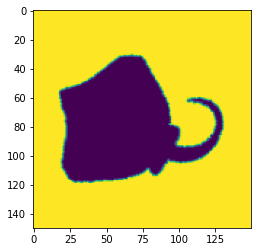

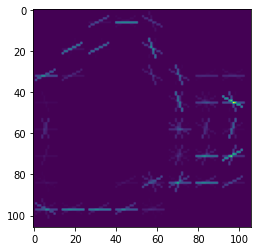

In [29]:
im = db.query("clas=='ray'").image.iloc[7]


p = (200-155)//2

params = dict(
    orientations=5,
    pixels_per_cell=(13,13),
    cells_per_block=(1,1), 
    visualize=True
    )

im_f = cv2.blur(im,(5,5))
fd, hog_image = skimage.feature.hog(im[p:-p,p:-p], **params)

print(fd.shape)
plt.imshow(im)
plt.figure()
plt.imshow(hog_image)

def hog_desc(im):
    im_f = cv2.blur(255-im,(5,5))
    fd, hog_image = skimage.feature.hog(im_f[p:-p,p:-p], **params)
    return fd

In [31]:
queries, results = test_queries(hog_desc, cosine_distance, top_n=12)
show_query_results(queries, results)
show_query_accuracy(queries, results)

queries:


,elephant,turtle,classic,key,bird,brick,children,camel,fork,fountain,heart,car,bone,ray,hammer,face,misk,glas
0,"<img src=""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJYAAACWCAAAAAAZai4+AAALLUlEQVR4Ac3BeVzT9R8H8Nd7G4xj4FAQ8UJMK4888Egfkfl7WJZXh5a3mGK/0Pqp4IEXWr/EW1EztTKyMoNELX+emeLPO4/SSkTN1PD4IQEDQXBje//YvuNwbGN+2R+f55MYIiKGiIghImKIiBgiIoaIiCEiYoiIGCIihoiIISJiiIgYIiKGiIghImKIiBgiIoaIiCEiYoiIGCIihoiIISJiiIgYIiKGiIghImKIiBgiIoaIiCEiYoiIGCIihpv9t4sPwIRaIYbbHA5fPnpc7PsRxquX4lrfCm3tC9mI4S5Zr3Tfpc0ofaCEiT0U3KFxp0GBPmrIQgx30G/afEVXpDKQiWGlVPihTVS/QMhBjFrjwtv7kk8bGTaIVY0HBL/YGY+OGLVV9P2xuqtKDLBHoVa2mBfh4afAoyFGLelPjr6rvAeHVPU9/zG2gwaPhBi1Yrq55twBE5wheHfr2uLZx/EIiFErui8TCkpQE7VX+LQX2AMuI0YtmHTHZ10wwQXa5o16D68LVxGjFm4k/HDbAFcolMqgiVPhKmLIYrqfm1twZdPPBXCZ4qU5Hb3gGmI8isw9d55rduOvonZNd14q/UN31oBH4D8w7km4hhguK71z+aed1wI9i4sVDb0uF9F9UwkeyRNjBrWAS4jhshvrd+TnloABhYoNeHTq8MmD4RJiuEq/elkWakcb8XZ/uIIYrtqScB61pPB/MxGuIIZrfj26/VgxaovCosfWQ82I4ZI7SSnXihi1pui5oJ03akQMlxxZcFAPd6jXa3BEMGpCDFfoty/+Be6h6Rw1EjUhhityEjbmwU38+8R1RA2I4YqbMVsZbqIMGrxcBeeI4YrvlpwxwG0iUoPhHDFccXzN3jy4TfOYfmFwihiuOLFkfxHcxis8dhCcIoYLMpd//TfcKKDP2F5whhguSI/dB3dSd37veThDDBfkRm+BO6laxo5RwgliuOBg/AmGOym7basPJ4jhgt3rjuTDrZ78vBucIIYL0pdt18GtQhNGwAliuGDvvFNwr/qTZsEJYtTs3tcrL8G9/N9YqYFjxKjOmF3cRIVKdydv1cO9PNpMHaaAQ8SoLmtd4RwtKp2fcpDhZnWjPlDDIWLY+lGXsVB1PpRQIXH1DYYbedcrKAiZOrQhHCKGjfRR13SMY11VKJc7/6u/4U6Nn790QtN3YXM4RAwba5feYGDBkFAlrI4uOFQMdwobmfVJ/Zh3NXCIGDZOL9tWCrSJjvSHxLA14Xe4VfAbbRJv9XjrNThEDFuJM0rVJdx3ancvWOQtTcqCO1Fg5KStMR7dkkMIDhDD1sH5vvixxL/z501hkRm1H25Frea/+tu4dJ/xQ8K8mWAPMWwV5Tb6alI+6hxtQzDbM+cXxkOUHh5+mpwcyBWR0rD0wpITuudHhjRqCHuIYcekb3JM2NfTE2Zxn+XgYYFPBrXtkPZ9JuRRPP1RRyAnafuVANW/RrMvqiOGPa/se4D1w/1g9uGK66jCIyik7YCG2paZSfMhT53+s1sBKDqwZX/+4D6a/qiOGHYYp2woqvNBZB2Y7Yj/FZUUzcaNDUaZWx8thDxNYifDzHAl9Yvriog0VEcMO27NTC3uvbY5weznicdQSTtkSkuUMR1755IesmgjV8HCpDs5/VLI6UAlbBHDjv+MzkO35FBYZL25jyGpq7r3TFwvgpnx8FtXIYvXq5sJEr75dG70zGDYIkZ1vG2cDu2+C4NF6ajUUlhoIr1ORo7QQHI+Jg2y1I1cpIZV4aS0wq3PwhYxqtM3+x8jIao+wSxj9p5iWPTteLnNmKaw+jMhCbJ0++QpVNB/eXNwa9gihh09TpSiS8KzXjBLXPkXLFT9pndVoULWuvchS9vFfVEDYtgRtbkEQ2a29oBZ8r8vwkzx+KShWlQqTBkHZ4hhX+iU8So4Rww7Fi4oRNjIiYEoY/x2fjrMgiLHP4YqireOghNqrxI9oxyBUS7glZh2cI4Y1Rm/mpyP1qsj1ChzY0wazJR9ZnVHVUeG3oZDSvWATj8eL4SEvANL7qKC18vJBKeIUV36i7cYvuEbw2BUGO4P3wszxbwpvqjq5wk/waGWE/s0ufDucUi0cyOXLjOiQsQufzhFjOpYH3YHwJGQwL1tNqdkGmDWLHZkAKrgjPe+RSViVNUiuRPujt7HkMydszvhVz3DquPGpwjOEMOeHicNgEfp+PPqP28ZYKaOin0MVd1Zt7AUFSgom1HVoeeAVWuuGWExYU7I2XW7shiSkDHD2sIZYtgzNrkYD+sf3xUPyftyMipQyLl+p1HVVwN9cOG93fdhMTi+LTJTN/4Kq4bTJsMZYtiz5pMMA6pqvag/4SGGHa+jgv/h9g86XGJUSvhnINasuAaL8Bkvq8HnFqTCKuDNFXCGGPaUnlizqwhVhCQOgY20QXko57c7wrRqQ4YJFcbEh+FI0q5smPl1je0LFKevTYJE1XzcNDhBDLuMmSnL/taEhf6UDY9GefmInxgIG2fGn0E5n+XR0MevKEW5sBlvBCDvyw+vwozqx78DoHD9NFgpwtM0cIwY9pn0h+qGeiu2rbiw/JmE3f3iwlWwcXH2dlh5DljZGDi9cYMeVvWHxoZC9+na67CgefMA8NfvFMCq1ZY2cIwYjhgUCsKDs/q269Y3nNrHH7b+WvYhrDxf2q4ASs/2KoKVwm9HD/AP7502wmxofGuU2Tn9qh6S0MTX4BgxnDNgy1rj4EFNCLZykqbDStnqN5QpbHgP5YbPflKB+I+zYRE8eHwrACWHF6VBEhwXA8eIUZOdx18M91HCVumh8X/ASrM4WgGAD0zOMELy/tvBuLtoUzYsuszo74ky5+enQlJn9Co4RoyaFD3QeKI6zv0mXgdJwK7uMFuyOI8hmRDX1LBpxUUjLNrPHYgy2Z8uLITE64UdcIwYcplOj/sdFureK1rA7PxnG4ohGbDkwfwjuQZIGs99C0BxyuzbsKL2R33hEDHkykxcXwwLzeR4T5jpU8cXQNLhM03UUVgpRs1uCSBt7nETrBpMn6CGQ8SQ6/ri9ZB4j/oYkjO98yCpu23fhmxYUcycACB9VUo+rLSvT2tJcIgYct1dPw8WVC92JiT5LbMhUX4TtCztPiTtpg30AQ7MO2GCGfk+1nF4Tw84Rgy5ir4dC0nIyaaQmLqcN0KyYtiaT++iTJ1Gob1eDVMA11K+uaAwAAgaEeVXTwMniCGX6cArxbAIPvYYrEbs1ZlgERO7+xN9k7BmTYP9fQICPAAY7lzJPHUyrEnTlh0bwzliyHZq+FWYqVp/0QFWGeuSCmHRcUhPJfn4+vp6KmBlMhhycjQ+Pj5eqAExZMrev3dnHsz8ouf4o9x3C84ZYOYVntiFIBMx5Ck6tOrUPRPMNNFLUeG31NU6WAQm94JcxJDDpDubnFoAiW/kWpQzjMq4qIfF8PgnCDIRQ478HWtuZEFCjb8LR7m5iYWw6jmxlz9kIoYMpoOxv6FC6DktrFLiMk2wipj1nA9kIoYMvG3MPZTTxkzzhuTU7CMPUK7f/HYKyEQMGf5YmVQMic8zLw1pBKsTH257AIlflz5DG0MuYshw89ut2cHe1694BjdoPvAFLcFKtye6AGaqwFbvdmqghlzEkMGYlZGvVVy+GRyorRcaiEqZX6z2Dkrvd2hM+wadtJCPGHKVFpn8lXiYUbfTU/v9sF8GNiHUBjFERAwREUNExBARMUREDBERQ0TEEBExREQMERFDRMQQETFERAwREUNExBARMUREDBERQ0TEEBExREQMERFDRMQQETFERAwREUNExBARMUREDBERQ0TEE

results:


Accuracies:


,elephant,turtle,classic,key,bird,brick,children,camel,fork,fountain,heart,car,bone,ray,hammer,face,misk,glas
Accuracy,,,,,,,,,,,,,,,,,,
0,0.833333,0.916667,1.0,1.0,0.666667,0.833333,1.0,0.833333,1.0,1.0,1.0,1.0,0.916667,0.25,0.75,1.0,0.833333,1.0


Average along classes: 0.88


In [32]:
import torch
import clip

model, preprocess = clip.load("ViT-B/32", device="cpu")

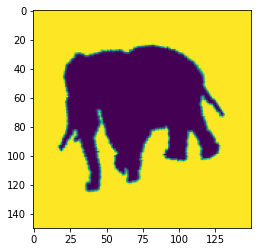

In [33]:
plt.imshow(db.image.iloc[0])
plt.show()

In [34]:
im = db.query("clas=='bird'").image.iloc[0]

In [35]:
from PIL import Image

image = Image.fromarray(np.uint8(255 - im))
device = "cpu"
image = preprocess(image).unsqueeze(0).to(device)
text = clip.tokenize("a " + db.clas.unique()).to(device)

with torch.no_grad():
    image_features = model.encode_image(image)
    text_features = model.encode_text(text)
    
    logits_per_image, logits_per_text = model(image, text)
    probs = logits_per_image.softmax(dim=-1).cpu().numpy()

print("Label probs:", probs)  # prints: [[0.9927937  0.00421068 0.00299572]]

Label probs: [[3.6951452e-03 3.0402683e-03 1.2549338e-03 2.8229712e-03 9.2807835e-01
  1.1033450e-03 5.0930837e-03 1.7129609e-02 2.3722611e-03 2.4109094e-04
  4.4398271e-03 1.8589041e-03 1.3696698e-02 6.5771262e-03 1.6354192e-03
  9.8805339e-04 5.2082278e-03 7.6466706e-04]]


In [36]:
i = np.argmax(probs)
db.clas.unique()[i]

'bird'

In [37]:
def clip_embedding(im):
    image = Image.fromarray(np.uint8(255 - im))
    device = "cpu"
    image = preprocess(image).unsqueeze(0).to(device)

    with torch.no_grad():
        image_features = model.encode_image(image)

    return image_features.numpy().flatten()

In [38]:
queries, results = test_queries(clip_embedding, l2Dist, top_n=5)
show_query_results(queries, results)
show_query_accuracy(queries, results)

queries:


results:


Accuracies:


,elephant,turtle,classic,key,bird,brick,children,camel,fork,fountain,heart,car,bone,ray,hammer,face,misk,glas
Accuracy,,,,,,,,,,,,,,,,,,
0,0.916667,0.916667,0.75,0.166667,0.916667,0.416667,0.916667,0.666667,0.75,1.0,1.0,0.666667,0.75,0.5,0.583333,0.916667,0.833333,0.916667


Average along classes: 0.75


In [72]:
queries, results = test_queries(clip_embedding, l2Dist, top_n=5)
show_query_results(queries, results)
show_query_accuracy(queries, results)

queries:


,elephant,turtle,classic,key,bird,brick,children,camel,fork,fountain,heart,car,bone,ray,hammer,face,misk,glas
0,"<img src=""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAHMAAABdCAAAAACzjgZ8AAAC8UlEQVRoBb3BCUKjAADAwOT/j84CQqEth1rWGePPGX/O+HPGT5jxKeMbzEBW8XvGFdmT8UvGOTkRv2GcklPxC8YpORc/Z5ySU/ELxhk5F79gnJBL8WPGCfme+AnjmPxMZmacMo7Jr8Ux45h8II4Yh+QjccA4Ip+KXcYh+VjsMI7IHeKNcUTuEG+MI3KLeGUckJvEC+OA3CWeGQfkLvHMOCC3iSfGPrlRbBkH5D6xZeyTW8XK2Cf3igdjn9wrHoxdcrdYGLvkdjEz9sh/EF+MPfIfxBdjj/wH8cXYI/9DTIwd8iS5RUyMHbIVyB1iYryTSTIIkHvEyHgno5BBDOQWMTLeyCghIQZyixgZr2SShMRI7hAT45WMYiQxklvEyHgho3git4iR8UxG8ULuECPjiYzildwhRsaWjOKN3CFGxkom8U5uEBNjJYPYI3eIkfEgEPvkDjEyZjKKfXKDmBgTGcURuUFMjJGM4pDcICbGQEZxTG4QEwNkECfkY0lMDBCIM/KxjC/GQOKUfCyJifEd8qnAmBjfIZ8KiYnxDbIj+YHAmBjfIC9iIt8WSIyMb5Bn8UVehSHvAomR8Q2yFQ/yLEbyLsAYGddkK1byLAaySBYBEgPjmmzElmzFSBbJIkAIMK7JRmzJVoxkETKLgRAY12QVz2QjRjILZBYDCTAuyUa8kFUMZBHILEYGGJdkFa9kFSOZBTKLkQHGJVnFK1nFSL4EyCwejCuyinfyEAOZBcgsHowrsoo3soqBzAJkEQvjijzEDnmIgcxiILNYGBdkFe9kFQOZxUBmsTAuyCp2yEMM5EuMZBYL44I8xB55CJBFDGQWC+OcrGKPPATIIgYyi4VxSlaxS1aBLAJkEQvjjGzELlmFPATIIhbGGVnFLtkIeQiQSWwYx2Qr9slG8hD7jEPyLPbIVpiZGQeMQ/Is9shWXDOOyLPYIS/iknFMFnFAnsU14yPyLK4ZH5Fncc34iGzFdxifMTMzvsv4c8afM/7cP/Q8MBDSGrxbAAAAAElFTkSuQmCC"" width=""100"" >","<img src=""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAHMAAAByCAAAAABFdLGfAAAClElEQVRoBb3BAWKCQADAsPb/j+506kQFRDiXGP/O+HfGvzP+nXElF/FtxpnJXXyVcSZP4nuME3kRX2OcyKv4FgNkTnyJATIv3jB2MEDmxSOB+GXyKz5mgCyJCZkXnzFOZEHcyZL4iHEii+JGlsUHjDNZEleyKjYzfpksiDN5JzYy/sgxsY1xJ8fEJsaEHBQbGFNyTGxgPJJj4i3jmRwS7xgzZL94x5gjB8Q6Y57sFuuMebJfrDIWyV6xxlgi+8UKY4EcEcuMeXJMLDLmyHGxwHglI8QC44UMErOMZzJMzDEeyUgxw3gkQ8Ur40a+IV4YV/Id8cy4ki+JJ8aVfEk8Ma5kVnJYPDCuZEYgh8UD40ZeBchhMWX8kSdxJgPEnTEhU3Ehx8WdMSETcSUDxB/jgdzEnRwXN8Yj+RVTclzcGM8MY8JkhLgw1skwcWGsk2Hiwlgn48Qv4x0ZJs6Md2SYODPeklHizHhLhokTYwMZJE6MLWSQAGMLuUgOiRNjG4EAOSTA+JAcEWB8SI4IMD4m+wUYH5P9AozPyW4Bxg6yV4Cxh+wUYOwhOwUYu8g+AcY+skuAsZPsECfGTrJDnBh7yefixNhNPhVnxm7yqTgzDpDPxJlxgHwkfhlHyAfiwjhCPhAXxiGyWVwZh8hWcWMcJNvEjXGUbBF/jMNkg/hjHCYbxB/jOHkr7owB5J24M0aQdTFhjCDrYsIYQlbFhDGErIoJYwhZE1PGGLImJowxZEVMGYPIspgyBpFlMWUMISvigTGCrIkHxgCyJh4ZI8iyeGIMIMvimTGALIoXxgCyIOOFMYTMiFnGEPIq5hmDyERyErOMUeQuBGKWMYz8CYSYZYwkZ3EiMc8YzfhlzDP+nfHvjH/3A4zZ+wFZ3QpZAAAAAElFTkSuQmCC"" width=""100"" >","<img src=""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAHMAAAA1CAAAAABXKYtLAAABTklEQVRYCb3BC2KiUADAwOT+h85igQrWz6LyZozhjOGM4YyvMjMzMzP+MD4mr8WV8RYzOSZmxlHyppgZB8gnYmYcIJ+ImXGIvC9mxhHygZgZR8j7YmEcIe+LhXGEvC8WxgHygVgYB8gHYmHcI8SGcSHvi5Vxj3xfLIw75PtiZfwlZ8iMiXHDkNMEGHtyqgBjR04VE2NHzhVgXMnZYmKs5HwxMRYyQEyMhYwQYCxkgJgYKzlfTIyVnC8mxkJGCDBmMkZgXJgMEWBMZJjAABkmwEBGiQsDZJC4MGZyvvhhzOSgzMxM/kOsjJn8l7hHXopfxkJeiMdkJ+RG/DIW8kI8JluB3IhfxkqeimfkKiayE1fGSjaSG/GczOKHbMWGcSWrQHbiJYFYyUZsGBvyIyayE0fJKnaMR2Qj3iAXGTvGY7KIbzKeMTO+yxjOGM4Y7h8xmY0B3PpS9wAAAABJRU5ErkJggg=="" width=""100"" >","<img src=""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAHUAAAA5CAAAAAAt9Tt3AAABT0lEQVRYCcXBC2KiUADAwOT+h87iZysqKNJXmTEOYBzAOIBxAOMAxho5i/GMFXIVwxlLZCZGM57JvRjMeCKPYizjkTyLoYwHsigGMu7JihjHmJN1MYwxIy/EMMaNvBSjGD/kjRjE+CHvxBjGf/JeDGFcyRaxj5zEhXEmW8VGMknuxIlxJtsFGGsMTJbFxDiRz8UCeSfAmMgOMSNbBRgT+Z4AYyJfExNjIt8SJ8ZEviMujIn8oSROjCtjIn8onhgT+SuxxJjIL8SJzIScxSJjIntkzMhFXEksMyayR9wRiE2ME/lc7GZMZIfYzZjI52I/40w+kcQvGGeyWfyacSGbxAjGlWwQQxj/yXsxhPFD3oohjBt5LQYxbuS1GMSYkVdiFGNOXohRjDuyKoYx7smKGMd4Is9iJOOZPIqhjGVykzGUsUYuYjjjAMYBjAMYB/gH7dd8AevmhmoAAAAASUVORK5CYII="" width=""100"" >","<img src=""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAHsAAAB7CAAAAABxrKCjAAACxklEQVRoBcXBCZLaSAAAwar/P7ocu8zYOqFFoyDT+Brja4yvMb7G+BpjS/4TtzM25EfczFiTf+JWxpKsxJ2Mf2QrbmT8kgNxH+OHHIn7GA9yLG5jPMixuI3xICfiLsYPORE3MRbkQNzEWJIDcQ9jSQ7EPYwlORD3MFZkL+5hrMlO3MPYkJ24hbElW3ELY0c24hbGjmzELYw9WYtbGAdkKe5h7MlK3MM4IEtxD2NPVuIexp6sxD2MHVmLexg7shG3MHZkK+5g7MhW3MHYkZ24gbEjO3EDY0sOxOcZO3IgPs7YkiPxccaGHItPMzbkVHyUsSFPxccYa/JSfIaxJiPiA4wVGRWzjBUZFbOMFRkXc4wVuSCmGEtyTUwwluSieJ+xJFfF24wVuSzeZKzIZfEmY0XeEG8xVuQd8Q5jRd4T1xlr8pa4zliTN8VVxpq8Ky4y1uRtcY2xIW+LS4wNeV9cYWzI++IKY0veFxcYWzIhxhlbMiHGGVsyI

results:


,elephant,turtle,classic,key,bird,brick,children,camel,fork,fountain,heart,car,bone,ray,hammer,face,misk,glas
0,"<img src=""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAHMAAABdCAAAAACzjgZ8AAAC8UlEQVRoBb3BCUKjAADAwOT/j84CQqEth1rWGePPGX/O+HPGT5jxKeMbzEBW8XvGFdmT8UvGOTkRv2GcklPxC8YpORc/Z5ySU/ELxhk5F79gnJBL8WPGCfme+AnjmPxMZmacMo7Jr8Ux45h8II4Yh+QjccA4Ip+KXcYh+VjsMI7IHeKNcUTuEG+MI3KLeGUckJvEC+OA3CWeGQfkLvHMOCC3iSfGPrlRbBkH5D6xZeyTW8XK2Cf3igdjn9wrHoxdcrdYGLvkdjEz9sh/EF+MPfIfxBdjj/wH8cXYI/9DTIwd8iS5RUyMHbIVyB1iYryTSTIIkHvEyHgno5BBDOQWMTLeyCghIQZyixgZr2SShMRI7hAT45WMYiQxklvEyHgho3git4iR8UxG8ULuECPjiYzildwhRsaWjOKN3CFGxkom8U5uEBNjJYPYI3eIkfEgEPvkDjEyZjKKfXKDmBgTGcURuUFMjJGM4pDcICbGQEZxTG4QEwNkECfkY0lMDBCIM/KxjC/GQOKUfCyJifEd8qnAmBjfIZ8KiYnxDbIj+YHAmBjfIC9iIt8WSIyMb5Bn8UVehSHvAomR8Q2yFQ/yLEbyLsAYGddkK1byLAaySBYBEgPjmmzElmzFSBbJIkAIMK7JRmzJVoxkETKLgRAY12QVz2QjRjILZBYDCTAuyUa8kFUMZBHILEYGGJdkFa9kFSOZBTKLkQHGJVnFK1nFSL4EyCwejCuyinfyEAOZBcgsHowrsoo3soqBzAJkEQvjijzEDnmIgcxiILNYGBdkFe9kFQOZxUBmsTAuyCp2yEMM5EuMZBYL44I8xB55CJBFDGQWC+OcrGKPPATIIgYyi4VxSlaxS1aBLAJkEQvjjGzELlmFPATIIhbGGVnFLtkIeQiQSWwYx2Qr9slG8hD7jEPyLPbIVpiZGQeMQ/Is9shWXDOOyLPYIS/iknFMFnFAnsU14yPyLK4ZH5Fncc34iGzFdxifMTMzvsv4c8afM/7cP/Q8MBDSGrxbAAAAAElFTkSuQmCC"" width=""100"" >","<img src=""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAHMAAAByCAAAAABFdLGfAAAClElEQVRoBb3BAWKCQADAsPb/j+506kQFRDiXGP/O+HfGvzP+nXElF/FtxpnJXXyVcSZP4nuME3kRX2OcyKv4FgNkTnyJATIv3jB2MEDmxSOB+GXyKz5mgCyJCZkXnzFOZEHcyZL4iHEii+JGlsUHjDNZEleyKjYzfpksiDN5JzYy/sgxsY1xJ8fEJsaEHBQbGFNyTGxgPJJj4i3jmRwS7xgzZL94x5gjB8Q6Y57sFuuMebJfrDIWyV6xxlgi+8UKY4EcEcuMeXJMLDLmyHGxwHglI8QC44UMErOMZzJMzDEeyUgxw3gkQ8Ur40a+IV4YV/Id8cy4ki+JJ8aVfEk8Ma5kVnJYPDCuZEYgh8UD40ZeBchhMWX8kSdxJgPEnTEhU3Ehx8WdMSETcSUDxB/jgdzEnRwXN8Yj+RVTclzcGM8MY8JkhLgw1skwcWGsk2Hiwlgn48Qv4x0ZJs6Md2SYODPeklHizHhLhokTYwMZJE6MLWSQAGMLuUgOiRNjG4EAOSTA+JAcEWB8SI4IMD4m+wUYH5P9AozPyW4Bxg6yV4Cxh+wUYOwhOwUYu8g+AcY+skuAsZPsECfGTrJDnBh7yefixNhNPhVnxm7yqTgzDpDPxJlxgHwkfhlHyAfiwjhCPhAXxiGyWVwZh8hWcWMcJNvEjXGUbBF/jMNkg/hjHCYbxB/jOHkr7owB5J24M0aQdTFhjCDrYsIYQlbFhDGErIoJYwhZE1PGGLImJowxZEVMGYPIspgyBpFlMWUMISvigTGCrIkHxgCyJh4ZI8iyeGIMIMvimTGALIoXxgCyIOOFMYTMiFnGEPIq5hmDyERyErOMUeQuBGKWMYz8CYSYZYwkZ3EiMc8YzfhlzDP+nfHvjH/3A4zZ+wFZ3QpZAAAAAElFTkSuQmCC"" width=""100"" >","<img src=""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAHMAAAA1CAAAAABXKYtLAAABTklEQVRYCb3BC2KiUADAwOT+h85igQrWz6LyZozhjOGM4YyvMjMzMzP+MD4mr8WV8RYzOSZmxlHyppgZB8gnYmYcIJ+ImXGIvC9mxhHygZgZR8j7YmEcIe+LhXGEvC8WxgHygVgYB8gHYmHcI8SGcSHvi5Vxj3xfLIw75PtiZfwlZ8iMiXHDkNMEGHtyqgBjR04VE2NHzhVgXMnZYmKs5HwxMRYyQEyMhYwQYCxkgJgYKzlfTIyVnC8mxkJGCDBmMkZgXJgMEWBMZJjAABkmwEBGiQsDZJC4MGZyvvhhzOSgzMxM/kOsjJn8l7hHXopfxkJeiMdkJ+RG/DIW8kI8JluB3IhfxkqeimfkKiayE1fGSjaSG/GczOKHbMWGcSWrQHbiJYFYyUZsGBvyIyayE0fJKnaMR2Qj3iAXGTvGY7KIbzKeMTO+yxjOGM4Y7h8xmY0B3PpS9wAAAABJRU5ErkJggg=="" width=""100"" >","<img src=""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAHUAAAA5CAAAAAAt9Tt3AAABT0lEQVRYCcXBC2KiUADAwOT+h87iZysqKNJXmTEOYBzAOIBxAOMAxho5i/GMFXIVwxlLZCZGM57JvRjMeCKPYizjkTyLoYwHsigGMu7JihjHmJN1MYwxIy/EMMaNvBSjGD/kjRjE+CHvxBjGf/JeDGFcyRaxj5zEhXEmW8VGMknuxIlxJtsFGGsMTJbFxDiRz8UCeSfAmMgOMSNbBRgT+Z4AYyJfExNjIt8SJ8ZEviMujIn8oSROjCtjIn8onhgT+SuxxJjIL8SJzIScxSJjIntkzMhFXEksMyayR9wRiE2ME/lc7GZMZIfYzZjI52I/40w+kcQvGGeyWfyacSGbxAjGlWwQQxj/yXsxhPFD3oohjBt5LQYxbuS1GMSYkVdiFGNOXohRjDuyKoYx7smKGMd4Is9iJOOZPIqhjGVykzGUsUYuYjjjAMYBjAMYB/gH7dd8AevmhmoAAAAASUVORK5CYII="" width=""100"" >","<img src=""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAHsAAAB7CAAAAABxrKCjAAACxklEQVRoBcXBCZLaSAAAwar/P7ocu8zYOqFFoyDT+Brja4yvMb7G+BpjS/4TtzM25EfczFiTf+JWxpKsxJ2Mf2QrbmT8kgNxH+OHHIn7GA9yLG5jPMixuI3xICfiLsYPORE3MRbkQNzEWJIDcQ9jSQ7EPYwlORD3MFZkL+5hrMlO3MPYkJ24hbElW3ELY0c24hbGjmzELYw9WYtbGAdkKe5h7MlK3MM4IEtxD2NPVuIexp6sxD2MHVmLexg7shG3MHZkK+5g7MhW3MHYkZ24gbEjO3EDY0sOxOcZO3IgPs7YkiPxccaGHItPMzbkVHyUsSFPxccYa/JSfIaxJiPiA4wVGRWzjBUZFbOMFRkXc4wVuSCmGEtyTUwwluSieJ+xJFfF24wVuSzeZKzIZfEmY0XeEG8xVuQd8Q5jRd4T1xlr8pa4zliTN8VVxpq8Ky4y1uRtcY2xIW+LS4wNeV9cYWzI++IKY0veFxcYWzIhxhlbMiHGGVsyI

Accuracies:


,elephant,turtle,classic,key,bird,brick,children,camel,fork,fountain,heart,car,bone,ray,hammer,face,misk,glas
Accuracy,,,,,,,,,,,,,,,,,,
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.2,1.0,1.0,1.0,1.0,0.6,0.4,1.0,1.0,1.0


Average along classes: 0.90


In [58]:
import torchvision.models as models

vgg16 = models.vgg16(pretrained=True)

def vgg_embedding(im):
    image = Image.fromarray(np.uint8(255 - im))
    device = "cpu"
    image = preprocess(image).unsqueeze(0).to(device)
    return vgg16.avgpool(image).numpy().ravel()

In [71]:
queries, results = test_queries(vgg_embedding, l2Dist, top_n=5)
show_query_results(queries, results)
show_query_accuracy(queries, results)

queries:


,elephant,turtle,classic,key,bird,brick,children,camel,fork,fountain,heart,car,bone,ray,hammer,face,misk,glas
0,"<img src=""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAHMAAABaCAAAAACuizbEAAACz0lEQVRoBb3BC2KiUADAwOT+h84+UD62Yl2hnTH+nPHnjD9nXMHMeI9xinwRPzLOkO/iB8bH5EC8ZHxKjsULxmfktThkvMN4ID+LA8aP5Cbu5C3xnPED+Vw8Y7wmZ8QTxmtySnxnvCJnxTfGC3KB+MJ4QS4QXxgvyBXikXFMrhEPjGNykdgzDslVYs84JJeJHeOIXCd2jCNyodgYR+RCsTGOyJViZRyQS8XKOCDXioVxQK4VCwNMiAdytbgzkEk8kKvFnQEyxJ5cL24MkEnsyPXixhhkiI38hpgZExliJb8hZsZMIBbyO2JizARiIb8iZsZMhriT3xETYyYQd/ILEmJizATiTn5BCDEYExniTn5BSEyMiUAs5Ca5TkhMjIlALGQWcpMEckZITIxBhljILOQmZnJCCDEYg0AsZBYyiYWcEEIMxiBD3MksZBILOSGEGIxBIBYyi6/khEBiMEAmcSeT+EZOCImJMQjEnUziOzkhkBiMQSYxk0l8J58LkBiMQSYxyCyekM8FSAzGIF/FE/K5GCTAmMijeEJOiEECjJnsxTNyQkwkMO5kFc/ICbExFnIXT8kJsTF2zDgiJ8TGeJecEBvjXfJSIEdix3iT7IU8CuRI7Bjvkk2APAjkSOwY75KdQB4EyCrZiR3jTbITg+zEIKuQndgY/0NuYpCdGGQRyE5sjM/JJgZZBMgmNsbnZBODLGKQTayMz8kmBrmLiaxiY5wgqxjkLm5kESvjc7IJkEXMZBUr4wRZBcgqJrKJhfE52QTIIm5kFQvjBFkFsoobWcXCOEFWgaziRlaxME6QVSCLuJFNLIwTZBWyiYnsxMI4QVYhq5jJTiyMM2QRsoiZ7MXCOEMWgcziRvZiZZwhi/hGdmJlnCCr+E4WsWN8THbiGUnikfEx2Ym3GZ+SvXib8SnZi7cZH5NNvM/4nNzF/zBOMeM/GX/O+HPGn/sH4NkeEA65UfsAAAAASUVORK5CYII="" width=""100"" >","<img src=""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAH4AAABBCAAAAAAyZE8sAAABq0lEQVRoBcXBCWKiQAAAwe7/P7rXHG7EwDAG1CrjnYx3Mt7JeCfjGLkIMzMeY/yBmWzImGU8TCZk7DMeJdNih/EQeUwMGY+QR8WIMUn+KLYZM+SA2GRcCLFNjoktBshS3JLDYoMBcid+yBlilQGyIj7JKWKVgayJCzlJrDJA1gTISWKVgaxLThOrDJBVyWlilQHyCvGbAfIacc+4kFeJBeODvEzcML7Iy8R/xhd5nbgyvslrxYXxn7xUgHFDniiMC/kQH4xb8hSxwViQJ4gtxh05XWwxluR0sclYktPFJmNJzhbbjAU5WYwYt+RkMWTck9PEDuMX45McFTuMTXJM7DIG5ICMPcaIHBF7jBGTA2KHMSZHxJgxIgfFkDEgc+KL3IkxY0QmxJXciyFjQK7ig1wlmbEgd2LMGJBvMUHuxQ5jQL7FBLkXO4xtchUT5F7sMLbJVUyQpdhlbJAfMUMukm+xz1gnt2KCXCSfYoaxTm7EFIEkJKYYa2QhJkkSQsww1shCzJOYZqyRhZhnzDPWyY94FmOdJJ/ieYx1koTEExljxhMZ72S8k/FO/wDEk6oBDnPE9gAAAABJRU5ErkJggg=="" width=""100"" >","<img src=""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAHMAAAA2CAAAAADRvfnlAAABR0lEQVRYCb3BAWKiQADAwOT/j86pCNWKXkHYGWM4YzhjOONrZmZmZmZ8YOxi8hfxythINosnxgayV/ww/ky+EAvjj+QrsTC2kN1iZmwhu8XM2ET2ipmxiewVM2ML2S1mxiayV8yMNRKvJNkrZsYKk5iZmck3YmasEpIjxcxYIYeLhfFKThAz45WcIGbGE4HkBDEzHsiJ4s6YybnizriTs8XEmMjpkrgwbmSIuDBuZIS4MiYyRIAxkSECjImcLibGjZwvIcC4MBkiLgyQcQIDGSfAABkkCQyQAcK4Ma7kdDEzbuRYgTyKhTGR/4gr+SDjhzyKhXEnn8SdPMnMWCEP4odxJ5/EdrKIB8ZC3osd5C4eGQ/kKvktdhIynhgr5Jc4kLFCnsWRjBXyLI5krJEncSRjnSziWMYbMomjGW+ZGYczhjOGM4b7B4HejwHRNdIJAAAAAElFTkSuQmCC"" width=""100"" >","<img src=""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAHQAAAA8CAAAAACS+sH6AAABV0lEQVRYCb3BB2LiQADAQOn/j9YZU45iJ2A2O2PMZ8xnzGfMZ+wwIWM8Y4esYjxjm1zEcMYmuYnRjC1yL8YyNsiDGMt4JU9iKOOFbIhxjGeyJ2ME44n8JAYw7sk74jvGHXlP/M6QkJPMjDPjjrwpnphh3MirODOu5H3JEbEyLmSCODHOZIY4MVYyRyyMhUwTYCxkmgBjIbPEwljIJHFiLGSOWBkLmSLOjBOZIC6MhfyxhLgyFvKn4pGxkK+EEAu5E3IST4yFHJXEibGSqwDJeGYs5KA4wljIQXGEcSIfCyGOMFbyqZA4xDiTz8RxxpV8Io4zbuRd8RXjP3lTfMV4IL+I7xmP5AcZAxiPZFcMYryQTTGK8Uo2xDDGBnkWAxkb5FkMZGySBzGSsU0exEDGDrmJsYw9chGDGbtkFaMZ+2QVgxm7ZBWjGftkEcMZ8xnzGfMZ8xnz/QN3wIkBHkImZAAAAABJRU5ErkJggg=="" width=""100"" >","<img src=""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAHMAAABgCAAAAAALahIPAAACFElEQVRoBb3BCWKjSADAQOn/j9ZuBowPMPHRnSrjzxl/zvhzxh0zYyrjSjYxj3Ehd2IWYyX3YhZjJQ9iEmMhj2IS4x/ZizmMH3IkpjD+J4diCgPkWExhgByLKQyQJ2IGA3kmZjBAINmLGYyNPIoZjCt5EDMYV/IoJjA2shMTGFfyKCYwNrITExgb2YvxjI3sxXjGRvZiPGMjezGecSFHYjhjIwdiOONCDsVoxoUcitGMCzkWgxkX8kSMZazkuRjJuJDnYiBjJWdiHGMl52IUYyW/iTGMlfwqhjBW8oIYwFjJS+JrxkpeE98yFvKy+I6xkNfFV4yFvCO+YCzkPfExYyFvik8ZC3lbfMZYyNviM8ZCPhCfMBbykXifsZAPxbuMhXws3mOs5GPxFmMlX4g3GBfyhXidsZLvxKuMC/lSvMa4kG/FS4yNfC1eYGxkhPiNsZEx4pxxJaPECeOGDJRxyLghw8WOcUumiFvGHZkibhj3ZIaMjXFPpomF8UimiR/GI5kowNiTeQLjgMwSYBySOQKMJ2SGAOMpGS/AOCGviR/yuwDjlJyIR3Iu/meckqfimDwT/xin5Kl4To7EP8YpeSJ+IQ9iZZyRvXiVXMXGOCN34l2yio1xRm7FEMYZuYpBjBOyiWGME3IR4xjPyI0Yx9iTBzGSsSdHYhBjR47FGMaO/IiFxA+BGMHYM2Yy/pzx54w/9x8zu8gBPACeQgAAAABJRU5ErkJggg=="" width=""100"" >",,"<img src=""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAH4AAAB7CAAAAACXhWvnAAACdElEQVRoB

results:


,elephant,turtle,classic,key,bird,brick,children,camel,fork,fountain,heart,car,bone,ray,hammer,face,misk,glas
0,"<img src=""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAHMAAABaCAAAAACuizbEAAACz0lEQVRoBb3BC2KiUADAwOT+h84+UD62Yl2hnTH+nPHnjD9nXMHMeI9xinwRPzLOkO/iB8bH5EC8ZHxKjsULxmfktThkvMN4ID+LA8aP5Cbu5C3xnPED+Vw8Y7wmZ8QTxmtySnxnvCJnxTfGC3KB+MJ4QS4QXxgvyBXikXFMrhEPjGNykdgzDslVYs84JJeJHeOIXCd2jCNyodgYR+RCsTGOyJViZRyQS8XKOCDXioVxQK4VCwNMiAdytbgzkEk8kKvFnQEyxJ5cL24MkEnsyPXixhhkiI38hpgZExliJb8hZsZMIBbyO2JizARiIb8iZsZMhriT3xETYyYQd/ILEmJizATiTn5BCDEYExniTn5BSEyMiUAs5Ca5TkhMjIlALGQWcpMEckZITIxBhljILOQmZnJCCDEYg0AsZBYyiYWcEEIMxiBD3MksZBILOSGEGIxBIBYyi6/khEBiMEAmcSeT+EZOCImJMQjEnUziOzkhkBiMQSYxk0l8J58LkBiMQSYxyCyekM8FSAzGIF/FE/K5GCTAmMijeEJOiEECjJnsxTNyQkwkMO5kFc/ICbExFnIXT8kJsTF2zDgiJ8TGeJecEBvjXfJSIEdix3iT7IU8CuRI7Bjvkk2APAjkSOwY75KdQB4EyCrZiR3jTbITg+zEIKuQndgY/0NuYpCdGGQRyE5sjM/JJgZZBMgmNsbnZBODLGKQTayMz8kmBrmLiaxiY5wgqxjkLm5kESvjc7IJkEXMZBUr4wRZBcgqJrKJhfE52QTIIm5kFQvjBFkFsoobWcXCOEFWgaziRlaxME6QVSCLuJFNLIwTZBWyiYnsxMI4QVYhq5jJTiyMM2QRsoiZ7MXCOEMWgcziRvZiZZwhi/hGdmJlnCCr+E4WsWN8THbiGUnikfEx2Ym3GZ+SvXib8SnZi7cZH5NNvM/4nNzF/zBOMeM/GX/O+HPGn/sH4NkeEA65UfsAAAAASUVORK5CYII="" width=""100"" >","<img src=""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAH4AAABBCAAAAAAyZE8sAAABq0lEQVRoBcXBCWKiQAAAwe7/P7rXHG7EwDAG1CrjnYx3Mt7JeCfjGLkIMzMeY/yBmWzImGU8TCZk7DMeJdNih/EQeUwMGY+QR8WIMUn+KLYZM+SA2GRcCLFNjoktBshS3JLDYoMBcid+yBlilQGyIj7JKWKVgayJCzlJrDJA1gTISWKVgaxLThOrDJBVyWlilQHyCvGbAfIacc+4kFeJBeODvEzcML7Iy8R/xhd5nbgyvslrxYXxn7xUgHFDniiMC/kQH4xb8hSxwViQJ4gtxh05XWwxluR0sclYktPFJmNJzhbbjAU5WYwYt+RkMWTck9PEDuMX45McFTuMTXJM7DIG5ICMPcaIHBF7jBGTA2KHMSZHxJgxIgfFkDEgc+KL3IkxY0QmxJXciyFjQK7ig1wlmbEgd2LMGJBvMUHuxQ5jQL7FBLkXO4xtchUT5F7sMLbJVUyQpdhlbJAfMUMukm+xz1gnt2KCXCSfYoaxTm7EFIEkJKYYa2QhJkkSQsww1shCzJOYZqyRhZhnzDPWyY94FmOdJJ/ieYx1koTEExljxhMZ72S8k/FO/wDEk6oBDnPE9gAAAABJRU5ErkJggg=="" width=""100"" >","<img src=""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAHMAAAA2CAAAAADRvfnlAAABR0lEQVRYCb3BAWKiQADAwOT/j86pCNWKXkHYGWM4YzhjOONrZmZmZmZ8YOxi8hfxythINosnxgayV/ww/ky+EAvjj+QrsTC2kN1iZmwhu8XM2ET2ipmxiewVM2ML2S1mxiayV8yMNRKvJNkrZsYKk5iZmck3YmasEpIjxcxYIYeLhfFKThAz45WcIGbGE4HkBDEzHsiJ4s6YybnizriTs8XEmMjpkrgwbmSIuDBuZIS4MiYyRIAxkSECjImcLibGjZwvIcC4MBkiLgyQcQIDGSfAABkkCQyQAcK4Ma7kdDEzbuRYgTyKhTGR/4gr+SDjhzyKhXEnn8SdPMnMWCEP4odxJ5/EdrKIB8ZC3osd5C4eGQ/kKvktdhIynhgr5Jc4kLFCnsWRjBXyLI5krJEncSRjnSziWMYbMomjGW+ZGYczhjOGM4b7B4HejwHRNdIJAAAAAElFTkSuQmCC"" width=""100"" >","<img src=""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAHQAAAA8CAAAAACS+sH6AAABV0lEQVRYCb3BB2LiQADAQOn/j9YZU45iJ2A2O2PMZ8xnzGfMZ+wwIWM8Y4esYjxjm1zEcMYmuYnRjC1yL8YyNsiDGMt4JU9iKOOFbIhxjGeyJ2ME44n8JAYw7sk74jvGHXlP/M6QkJPMjDPjjrwpnphh3MirODOu5H3JEbEyLmSCODHOZIY4MVYyRyyMhUwTYCxkmgBjIbPEwljIJHFiLGSOWBkLmSLOjBOZIC6MhfyxhLgyFvKn4pGxkK+EEAu5E3IST4yFHJXEibGSqwDJeGYs5KA4wljIQXGEcSIfCyGOMFbyqZA4xDiTz8RxxpV8Io4zbuRd8RXjP3lTfMV4IL+I7xmP5AcZAxiPZFcMYryQTTGK8Uo2xDDGBnkWAxkb5FkMZGySBzGSsU0exEDGDrmJsYw9chGDGbtkFaMZ+2QVgxm7ZBWjGftkEcMZ8xnzGfMZ8xnz/QN3wIkBHkImZAAAAABJRU5ErkJggg=="" width=""100"" >","<img src=""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAHMAAABgCAAAAAALahIPAAACFElEQVRoBb3BCWKjSADAQOn/j9ZuBowPMPHRnSrjzxl/zvhzxh0zYyrjSjYxj3Ehd2IWYyX3YhZjJQ9iEmMhj2IS4x/ZizmMH3IkpjD+J4diCgPkWExhgByLKQyQJ2IGA3kmZjBAINmLGYyNPIoZjCt5EDMYV/IoJjA2shMTGFfyKCYwNrITExgb2YvxjI3sxXjGRvZiPGMjezGecSFHYjhjIwdiOONCDsVoxoUcitGMCzkWgxkX8kSMZazkuRjJuJDnYiBjJWdiHGMl52IUYyW/iTGMlfwqhjBW8oIYwFjJS+JrxkpeE98yFvKy+I6xkNfFV4yFvCO+YCzkPfExYyFvik8ZC3lbfMZYyNviM8ZCPhCfMBbykXifsZAPxbuMhXws3mOs5GPxFmMlX4g3GBfyhXidsZLvxKuMC/lSvMa4kG/FS4yNfC1eYGxkhPiNsZEx4pxxJaPECeOGDJRxyLghw8WOcUumiFvGHZkibhj3ZIaMjXFPpomF8UimiR/GI5kowNiTeQLjgMwSYBySOQKMJ2SGAOMpGS/AOCGviR/yuwDjlJyIR3Iu/meckqfimDwT/xin5Kl4To7EP8YpeSJ+IQ9iZZyRvXiVXMXGOCN34l2yio1xRm7FEMYZuYpBjBOyiWGME3IR4xjPyI0Yx9iTBzGSsSdHYhBjR47FGMaO/IiFxA+BGMHYM2Yy/pzx54w/9x8zu8gBPACeQgAAAABJRU5ErkJggg=="" width=""100"" >",,"<img src=""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAH4AAAB7CAAAAACXhWvnAAACdElEQVRoB

Accuracies:


,elephant,turtle,classic,key,bird,brick,children,camel,fork,fountain,heart,car,bone,ray,hammer,face,misk,glas
Accuracy,,,,,,,,,,,,,,,,,,
0,1.0,0.2,0.8,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.4,1.0,1.0,1.0


Average along classes: 0.91


In [67]:
queries, results = test_queries(vgg_embedding, cosine_distance, top_n=5)
show_query_results(queries, results)
show_query_accuracy(queries, results)

queries:


,elephant,turtle,classic,key,bird,brick,children,camel,fork,fountain,heart,car,bone,ray,hammer,face,misk,glas
0,"<img src=""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAHMAAABzCAAAAACOKGI6AAADdklEQVRoBb3BCWLiSADAQOn/j9aCL4xtCFl6UmX8OePPGX/O+BXja8ZvCMSXjE/JIr5jfEL24ivGB+RJfMX4mRzEN4wfyYX434yfyAvx/xg/kDcyfs14T34Qv2W8Jz+K3zHekw/EbxhvyUfiF4y35EPxMeMd+Vx8yHhHfiE+Y7wjvxCfMd6QX4mPGG/I74RhvGe8If9TvGG8Jv9fvGS8Jt+IF4xX5FtxyXhBBogLxjUZIs6MazJGnBiXZJQ4Mi7JMHFgXJGB4plxRUaKJ8YFGSx2jAsyWOwYZzJcPBhnMl5sjBP5F2JlHMk/ESvjSP6NWBgH8o/Ewngm/0zMjCfyD8XE2JMXku/FxNiRV0K+FhNjIy+FDBB3xkIWIUchA8SdMZNFIEfJCHFnTGQSN3IUMkTcGCCTmMlRyBBxY4DcxZ1cSAYJMEAgJnIhZJAAA4yVnIWMEmCcyF7cyCABxpHsxY0MExhH8hATGSXAOJJNzGSUAONAVrGQcQLjQFaxkGECjANZxUwGCowDWcRCxgkwnskqFjJQYDyTRaxknADjmSxiJeMEGE9kFSsZJm6MZzKLlYwTN8YTWcVChok744nM4kEGiYnxRGaxkVFiYuzJLB5klJgYezKLBxklJsaezGJHBomJsSOz2JFRYmLsyCz25HsJxMTYkVnsyUvJR0IgJsaOTOJB3ogb+VHITUyMB5nFg7wWM3kvQCAmxkZm8SCvxI7JS3EjEBNjJYvYyAtxIC/FjUBMjJXMYiPX4kReihu5iTvjTpJZPMilOJNXYiIQd8aNPMSDXIkzeSlmQtwZN7KJB7kSZ/JSLIS4M0A2sScncUVeioUQdwbIKp7IUVySV2IlxJ1xI4t4IkdxRV6LhRB3xkTu4kBINnFJXouVEHfGQogjIXmIC/JGrIS4M96RkE1ckSfJTmwk7owfyCauyLNANrGRuDN+IKs4M3kWIKvYCHFnvCerOJOjuJFVPEjcGW/JIs7kJO5kFWfGO7KKC3IQE1nEBeMdWcQFOYqJLOKC8ZbM4oo8i5ms4sz4iUBck71YyCrOjK/IQ6xkFWfGd2QVK9nEmfEtmcVKNnFmfEsmsZFNnBnfk5vYyCbOjAGEeJBNnBnDySYuGKPJQ1wwBpO9ODMGk704MwaTvTgzxpK9uGCMJpu4Yowns7hk/Dnjzxl/zvhz/wHX8lUQ8fABEgAAAABJRU5ErkJggg=="" width=""100"" >","<img src=""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAHMAAABQCAAAAAAPEBWiAAAB0klEQVRoBb3BC0KjABTAwOT+h85a6gcQWLWvnTFezng54+WMhZnxEsaNrMU14xEGyE6ck0X8mQHyTRwy2cn4HQPkmzggZ+IXDJADsZCbQC7FjxnIoQD5ufghA+RQyK/EjxjIoPgvA2RUXDNARsU1YyGT4orxTgbFBeODDIpzxheZE6eMLzIozhhrMidOGBsyJ44ZOzImDhl7MiUOGd/ImDhgHJEh8Z1xRMbEnnFMhsSecUKGxI5xSmbElnFKpsSacUqmxJpxTqbEinFK5sQX45zMiU/GOZkTn4wrMiU+GVdkTHwwLsmU+GBckjHxzrgmU+KdcUnGxDvjksyJO+OKDIo745LMiTvjigyKO+OCTIo745Qhk2JhnJFpsTBOyLhYGMdkI3lcLIxjshHysFgYx2Qj3siD4sY4JmuxkAfFG+OYrMWdPCRujEOyFp/k72JhHJMvsSF/FAvjjMQJk7+IG+Ov5PfijfEA+aV4YzxK/ivkLsCYImfiRt4EGMNkI+ODQGDMk5XYM55AVmLHeAZZiS3jGWQltoxnkJXYMp5AVmLHmCcbsWWMk63YMsbJVmwZ42QjdoxpshF7xjhZiW+MefIhDhjPIGEcM17OeDnj5YyX+wenm7QBQvU7IAAAAABJRU5ErkJggg=="" width=""100"" >","<img src=""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAHMAAAA0CAAAAACcdVjuAAABTElEQVRYCb3BB2KjAADAMPv/j/b1IKxmQgOScTnjcsbljG8yMzMzM+4ZfyRvxYZxiCF7xMzYR5IjYmJ8To6LmfE5OS5mxh5yVMyMHeSwmBl7yFExM3aQw2JmfE6Oi5nxiMQ9OSwWxiNC3JHjYmY8IiRJkiR/FTPjAfm2WBj35OtiYdyTk8R/xpacJwbGhpwoBsaGnCgGxsLkTDEwZnKyGBg3croYGCM5XwyMkZwvBsZIzhcDYyJni4FxI2eLkTGSSwQYCCHXCAyQywQYIJcJMECuEEKAgVwhJsZAThc3xkiOSt6KFWMkn4l78k6sGCN5J+MxWQvkl1gxbuS1eE5WAvklVowbeS2ek0WAbMWaMZNFshUvySgGshYbxkwmgWzFGwIxkUVsGSvyI+OHrMReMolfjGdkEfvJIH4znpJJfJPxgpnxZcbljMsZl/sH94qLAS999AkAAAAASUVORK5CYII="" width=""100"" >","<img src=""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAHQAAAA8CAAAAACS+sH6AAABQElEQVRYCb3BAY5TMRTAQPv+hzYvXUBCWki/GjJj3GfcZ9xn3GfcZ/xJfskA+RLnGF9Mkr+Kc4wvshHHGItsxTHGi2zFKcaQN8QpxpC9OMYYshfHGEP24hhjyF4cYwzZi2OMIW+IU4whe3GMMeQNcYox5B1xiDHkkfiMMeSZ+Igx5Jn4iDHkmfiGJPGbJPENY8gd8WIMuSQWY5FbAoxFbgkwhlwTYCxyS4CxyC0BxotcEmAsckuAMeSWGMaQawKMIdcEGEOuCTAW+Y+Sn+LFWOSpMCRDMkkIQ0JCQjIMCePFGPJQfMIY8kx8xBjyQMZnjCHvCuNTxpA3hHGE8SJbcYqxyFYcYyyyFccYQ/biGGORrTjGGLIV5xiLbMUxxiJbcYwxZCvOMRbZiXOML/JvcY7xkyTJt+Ik4z7jPuM+474fPFaNAVewojgAAAAASUVORK5CYII="" width=""100"" >","<img src=""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAHMAAABrCAAAAABhreLMAAACYElEQVRoBb3BB2LiQADAQOn/j9ZBcphm3PBmxvhzxp8z/pzx54wnAjGW8UiuYijjTn7FUMad/BcjGROZxEDGjTyKYYz/5EkMY/ySFzGK8UPexCDGD3kTgxhXMiPGMH7IuxjDuJA5MYYBMivGMEDmxRAGMi/GMEDmxRAGGCBvYghjIs9iDONOnsUQxp08iyGMibyKEYyJvIoRjDt5ESMYE3kTAxgTeRfnMyYyI05nTGROnM24kXlxMmMiH8SpjBv5KM5kTOSjOJFxI0viNMZElsRZjBtZEecwJrIiTmHcyLo4gTGRdfE940Y2iW8ZE9kmvmPcyFbxFWMim8UXjInsEIcZE9knjjHuZJ84xJjIbnGAcSe7xX7GnRwROxkP5IDYyXggh8QuxiM5JnYwnsgxsZ3xRA6LjYxnclgsMIG4MF7IcTFPbgKMV/KFeGCAPAowXsmXkiSZEWC8kpEC442ME2C8kXECjHcyTmDMkFECjBkySoAxR8aIC2OOjBEXxiwZIi6MWTJCXBnz5HTxy/hAzhU3xidyorgzPpHTxCPjIzlBvDE+k6/EPGOBHJCZ8ZGxRHaLNcYS2S3WGItkn1hnrJAdY

results:


,elephant,turtle,classic,key,bird,brick,children,camel,fork,fountain,heart,car,bone,ray,hammer,face,misk,glas
0,"<img src=""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAHMAAABzCAAAAACOKGI6AAADdklEQVRoBb3BCWLiSADAQOn/j9aCL4xtCFl6UmX8OePPGX/O+BXja8ZvCMSXjE/JIr5jfEL24ivGB+RJfMX4mRzEN4wfyYX434yfyAvx/xg/kDcyfs14T34Qv2W8Jz+K3zHekw/EbxhvyUfiF4y35EPxMeMd+Vx8yHhHfiE+Y7wjvxCfMd6QX4mPGG/I74RhvGe8If9TvGG8Jv9fvGS8Jt+IF4xX5FtxyXhBBogLxjUZIs6MazJGnBiXZJQ4Mi7JMHFgXJGB4plxRUaKJ8YFGSx2jAsyWOwYZzJcPBhnMl5sjBP5F2JlHMk/ESvjSP6NWBgH8o/Ewngm/0zMjCfyD8XE2JMXku/FxNiRV0K+FhNjIy+FDBB3xkIWIUchA8SdMZNFIEfJCHFnTGQSN3IUMkTcGCCTmMlRyBBxY4DcxZ1cSAYJMEAgJnIhZJAAA4yVnIWMEmCcyF7cyCABxpHsxY0MExhH8hATGSXAOJJNzGSUAONAVrGQcQLjQFaxkGECjANZxUwGCowDWcRCxgkwnskqFjJQYDyTRaxknADjmSxiJeMEGE9kFSsZJm6MZzKLlYwTN8YTWcVChok744nM4kEGiYnxRGaxkVFiYuzJLB5klJgYezKLBxklJsaezGJHBomJsSOz2JFRYmLsyCz25HsJxMTYkVnsyUvJR0IgJsaOTOJB3ogb+VHITUyMB5nFg7wWM3kvQCAmxkZm8SCvxI7JS3EjEBNjJYvYyAtxIC/FjUBMjJXMYiPX4kReihu5iTvjTpJZPMilOJNXYiIQd8aNPMSDXIkzeSlmQtwZN7KJB7kSZ/JSLIS4M0A2sScncUVeioUQdwbIKp7IUVySV2IlxJ1xI4t4IkdxRV6LhRB3xkTu4kBINnFJXouVEHfGQogjIXmIC/JGrIS4M96RkE1ckSfJTmwk7owfyCauyLNANrGRuDN+IKs4M3kWIKvYCHFnvCerOJOjuJFVPEjcGW/JIs7kJO5kFWfGO7KKC3IQE1nEBeMdWcQFOYqJLOKC8ZbM4oo8i5ms4sz4iUBck71YyCrOjK/IQ6xkFWfGd2QVK9nEmfEtmcVKNnFmfEsmsZFNnBnfk5vYyCbOjAGEeJBNnBnDySYuGKPJQ1wwBpO9ODMGk704MwaTvTgzxpK9uGCMJpu4Yowns7hk/Dnjzxl/zvhz/wHX8lUQ8fABEgAAAABJRU5ErkJggg=="" width=""100"" >","<img src=""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAHMAAABQCAAAAAAPEBWiAAAB0klEQVRoBb3BC0KjABTAwOT+h85a6gcQWLWvnTFezng54+WMhZnxEsaNrMU14xEGyE6ck0X8mQHyTRwy2cn4HQPkmzggZ+IXDJADsZCbQC7FjxnIoQD5ufghA+RQyK/EjxjIoPgvA2RUXDNARsU1YyGT4orxTgbFBeODDIpzxheZE6eMLzIozhhrMidOGBsyJ44ZOzImDhl7MiUOGd/ImDhgHJEh8Z1xRMbEnnFMhsSecUKGxI5xSmbElnFKpsSacUqmxJpxTqbEinFK5sQX45zMiU/GOZkTn4wrMiU+GVdkTHwwLsmU+GBckjHxzrgmU+KdcUnGxDvjksyJO+OKDIo745LMiTvjigyKO+OCTIo745Qhk2JhnJFpsTBOyLhYGMdkI3lcLIxjshHysFgYx2Qj3siD4sY4JmuxkAfFG+OYrMWdPCRujEOyFp/k72JhHJMvsSF/FAvjjMQJk7+IG+Ov5PfijfEA+aV4YzxK/ivkLsCYImfiRt4EGMNkI+ODQGDMk5XYM55AVmLHeAZZiS3jGWQltoxnkJXYMp5AVmLHmCcbsWWMk63YMsbJVmwZ42QjdoxpshF7xjhZiW+MefIhDhjPIGEcM17OeDnj5YyX+wenm7QBQvU7IAAAAABJRU5ErkJggg=="" width=""100"" >","<img src=""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAHMAAAA0CAAAAACcdVjuAAABTElEQVRYCb3BB2KjAADAMPv/j/b1IKxmQgOScTnjcsbljG8yMzMzM+4ZfyRvxYZxiCF7xMzYR5IjYmJ8To6LmfE5OS5mxh5yVMyMHeSwmBl7yFExM3aQw2JmfE6Oi5nxiMQ9OSwWxiNC3JHjYmY8IiRJkiR/FTPjAfm2WBj35OtiYdyTk8R/xpacJwbGhpwoBsaGnCgGxsLkTDEwZnKyGBg3croYGCM5XwyMkZwvBsZIzhcDYyJni4FxI2eLkTGSSwQYCCHXCAyQywQYIJcJMECuEEKAgVwhJsZAThc3xkiOSt6KFWMkn4l78k6sGCN5J+MxWQvkl1gxbuS1eE5WAvklVowbeS2ek0WAbMWaMZNFshUvySgGshYbxkwmgWzFGwIxkUVsGSvyI+OHrMReMolfjGdkEfvJIH4znpJJfJPxgpnxZcbljMsZl/sH94qLAS999AkAAAAASUVORK5CYII="" width=""100"" >","<img src=""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAHQAAAA8CAAAAACS+sH6AAABQElEQVRYCb3BAY5TMRTAQPv+hzYvXUBCWki/GjJj3GfcZ9xn3GfcZ/xJfskA+RLnGF9Mkr+Kc4wvshHHGItsxTHGi2zFKcaQN8QpxpC9OMYYshfHGEP24hhjyF4cYwzZi2OMIW+IU4whe3GMMeQNcYox5B1xiDHkkfiMMeSZ+Igx5Jn4iDHkmfiGJPGbJPENY8gd8WIMuSQWY5FbAoxFbgkwhlwTYCxyS4CxyC0BxotcEmAsckuAMeSWGMaQawKMIdcEGEOuCTAW+Y+Sn+LFWOSpMCRDMkkIQ0JCQjIMCePFGPJQfMIY8kx8xBjyQMZnjCHvCuNTxpA3hHGE8SJbcYqxyFYcYyyyFccYQ/biGGORrTjGGLIV5xiLbMUxxiJbcYwxZCvOMRbZiXOML/JvcY7xkyTJt+Ik4z7jPuM+474fPFaNAVewojgAAAAASUVORK5CYII="" width=""100"" >","<img src=""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAHMAAABrCAAAAABhreLMAAACYElEQVRoBb3BB2LiQADAQOn/j9ZBcphm3PBmxvhzxp8z/pzx54wnAjGW8UiuYijjTn7FUMad/BcjGROZxEDGjTyKYYz/5EkMY/ySFzGK8UPexCDGD3kTgxhXMiPGMH7IuxjDuJA5MYYBMivGMEDmxRAGMi/GMEDmxRAGGCBvYghjIs9iDONOnsUQxp08iyGMibyKEYyJvIoRjDt5ESMYE3kTAxgTeRfnMyYyI05nTGROnM24kXlxMmMiH8SpjBv5KM5kTOSjOJFxI0viNMZElsRZjBtZEecwJrIiTmHcyLo4gTGRdfE940Y2iW8ZE9kmvmPcyFbxFWMim8UXjInsEIcZE9knjjHuZJ84xJjIbnGAcSe7xX7GnRwROxkP5IDYyXggh8QuxiM5JnYwnsgxsZ3xRA6LjYxnclgsMIG4MF7IcTFPbgKMV/KFeGCAPAowXsmXkiSZEWC8kpEC442ME2C8kXECjHcyTmDMkFECjBkySoAxR8aIC2OOjBEXxiwZIi6MWTJCXBnz5HTxy/hAzhU3xidyorgzPpHTxCPjIzlBvDE+k6/EPGOBHJCZ8ZGxRHaLNcYS2S3WGItkn1hnrJAdY

Accuracies:


,elephant,turtle,classic,key,bird,brick,children,camel,fork,fountain,heart,car,bone,ray,hammer,face,misk,glas
Accuracy,,,,,,,,,,,,,,,,,,
0,0.416667,0.166667,0.916667,0.916667,0.833333,0.916667,1.0,0.416667,0.583333,1.0,1.0,1.0,1.0,0.833333,0.583333,1.0,0.583333,1.0


Average along classes: 0.79
